# 0.0. IMPORTS

In [2]:
import inflection
import datetime
import warnings
import random
import pickle # to save the results, and avoid the need for run xgbregressor again
import math

warnings.filterwarnings('ignore')

import seaborn as sns
import xgboost as xgb
import pandas  as pd
import numpy   as np

from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from IPython.display       import Image  # class display
from IPython.core.display  import HTML

from matplotlib            import pyplot as plt
from scipy                 import stats  as ss

## 0.1 Helper Functions

In [3]:
# after of take off the test dataset, get the training set and split it again in training and validation set
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, 6)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7) # 6 weeks
        validation_end_date   = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        # filtering dataset
        training   = x_training[ x_training['date']  <  validation_start_date]
        validation = x_training[(x_training['date']  >= validation_start_date) &
                                (x_training['date']  <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list. append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        #print(lr_result)
        
    return pd.DataFrame(
    {'Model Name': model_name,
     'MAE CV' : np.round(np.mean(mae_list ), 2).astype(str)  + '+/-' + np.round(np.std(mae_list ), 2).astype(str),
     'MAPE CV': np.round(np.mean(mape_list), 2).astype(str)  + '+/-' + np.round(np.std(mape_list), 2).astype(str),
     'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str)  + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, 
        index = [0])

def mean_percentage_error(y, yhat):
    return np.mean(((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cramer_v(x, y):
    # Cramér's V is a measure of association between two nominal variables
    cm   = pd.crosstab(x, y).values  # confusion matrix
    n    = cm.sum()
    r, k = cm.shape
    
    chi2     = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) # corr -> correction of parameters
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows    = None
    #pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) # false for the function load all data from the file
df_store_raw = pd.read_csv('data/store.csv', low_memory = False) # false for the function load all data from the file

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# Notes
#     Store - a unique Id for each store
#     Sales - the turnover for any given day
#     Customers - the number of customers on a given day
#     Open - an indicator for whether the store was open: 0 = closed, 1 = open
#     StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#     SchoolHoliday - indicates if the Store was affected by the closure of public schools
#     StoreType - differentiates between 4 different store models: a, b, c, d
#     Assortment - describes an assortment level: a = basic, b = extra, c = extended
#     CompetitionDistance - distance in meters to the nearest competitor store
#     CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#     Promo - indicates whether a store is running a promo on that day
#     Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
#     Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#     PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Promo2 is a coupon based mailing campaign that is send to customers of participating stores.

# Each letter contains several coupons, mostly for a general discount on all products which are valid for three months.

# So after/right before these coupons have expired we send a new round of mail to our customers

# 1.0 STEP 01 - DATA DESCRIPTION

## 1.1 Rename Columns

In [8]:
df1 = df_raw.copy() # to avoid damage in the original data, make a copy in each section of the notebook
# df1 = df1.drop(['month_map', 'is_promo'], axis = 1)
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers',                   'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',                     'StoreType', 'Assortment', 'CompetitionDistance',                     'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',                       'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new  = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data dimension

In [11]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
# When the competition distance column is empty we will assume that there is actually no competitor nearby, so we will replace this value with a distance much longer than the maximum, such as 200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month: let's assume that the competitive opening month is the same month of the date column
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(
                                                        lambda x: x['date'].month 
                                                        if math.isnan(x['competition_open_since_month']) 
                                                        else x['competition_open_since_month'],
                                                        axis = 1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(
                                                        lambda x: x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'],
                                                        axis = 1)
                       
# promo2_since_week: we are assuming the same date of the row, i.e., the store doesn't make the promo2
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(
                                                        lambda x: x['date'].week 
                                                        if math.isnan(x['promo2_since_week']) 
                                                        else x['promo2_since_week'],
                                                        axis = 1)

# promo2_since_year  
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year 
                                                        if math.isnan(x['promo2_since_year']) 
                                                        else x['promo2_since_year'],
                                                        axis = 1)

# promo_interval: built a list and if the date is on the list the promo was made
# dictionare
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 
             11: 'Noc', 12: 'Dec'}

# fill with 0 where in no values
df1['promo_interval'].fillna(0, inplace = True) # inplace so the command doesn't return any value and make the 
                                                # modification directly to the column

df1['month_map'] = df1['date'].dt.month.map(month_map) # trasnform date column in date and month, and substitute
                                                       # the numbers by letters

# if the months of 'month_map' are in 'promo_interval', we assume that the sales made that day was in the period of promo2
df1['is_promo']  = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                         if x['promo_interval'] == 0 
                                                         else 1 
                                                         if x['month_map'] in x['promo_interval'].split(',') 
                                                         else 0, 
                                                         axis = 1)

In [16]:
df1.sample(5).T

,716198,556072,673721,576979,962247
store,39,473,1047,195,788
day_of_week,5,2,2,4,2
date,2013-09-27 00:00:00,2014-02-18 00:00:00,2013-11-05 00:00:00,2014-01-30 00:00:00,2013-02-19 00:00:00
sales,4964,4766,12160,7971,18202
customers,629,589,565,1123,1716
open,1,1,1,1,1
promo,1,1,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [18]:
# checks whether the previous changes changed the types of the values
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']            = df1['promo2_since_week'].astype(int)
df1['promo2_since_year']            = df1['promo2_since_year'].astype(int)

## 1.7 Statistical Description

In [20]:
# separating numerical and categorical variables
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T # transform to dataframe to facilitate visualization
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T # skewness
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [22]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


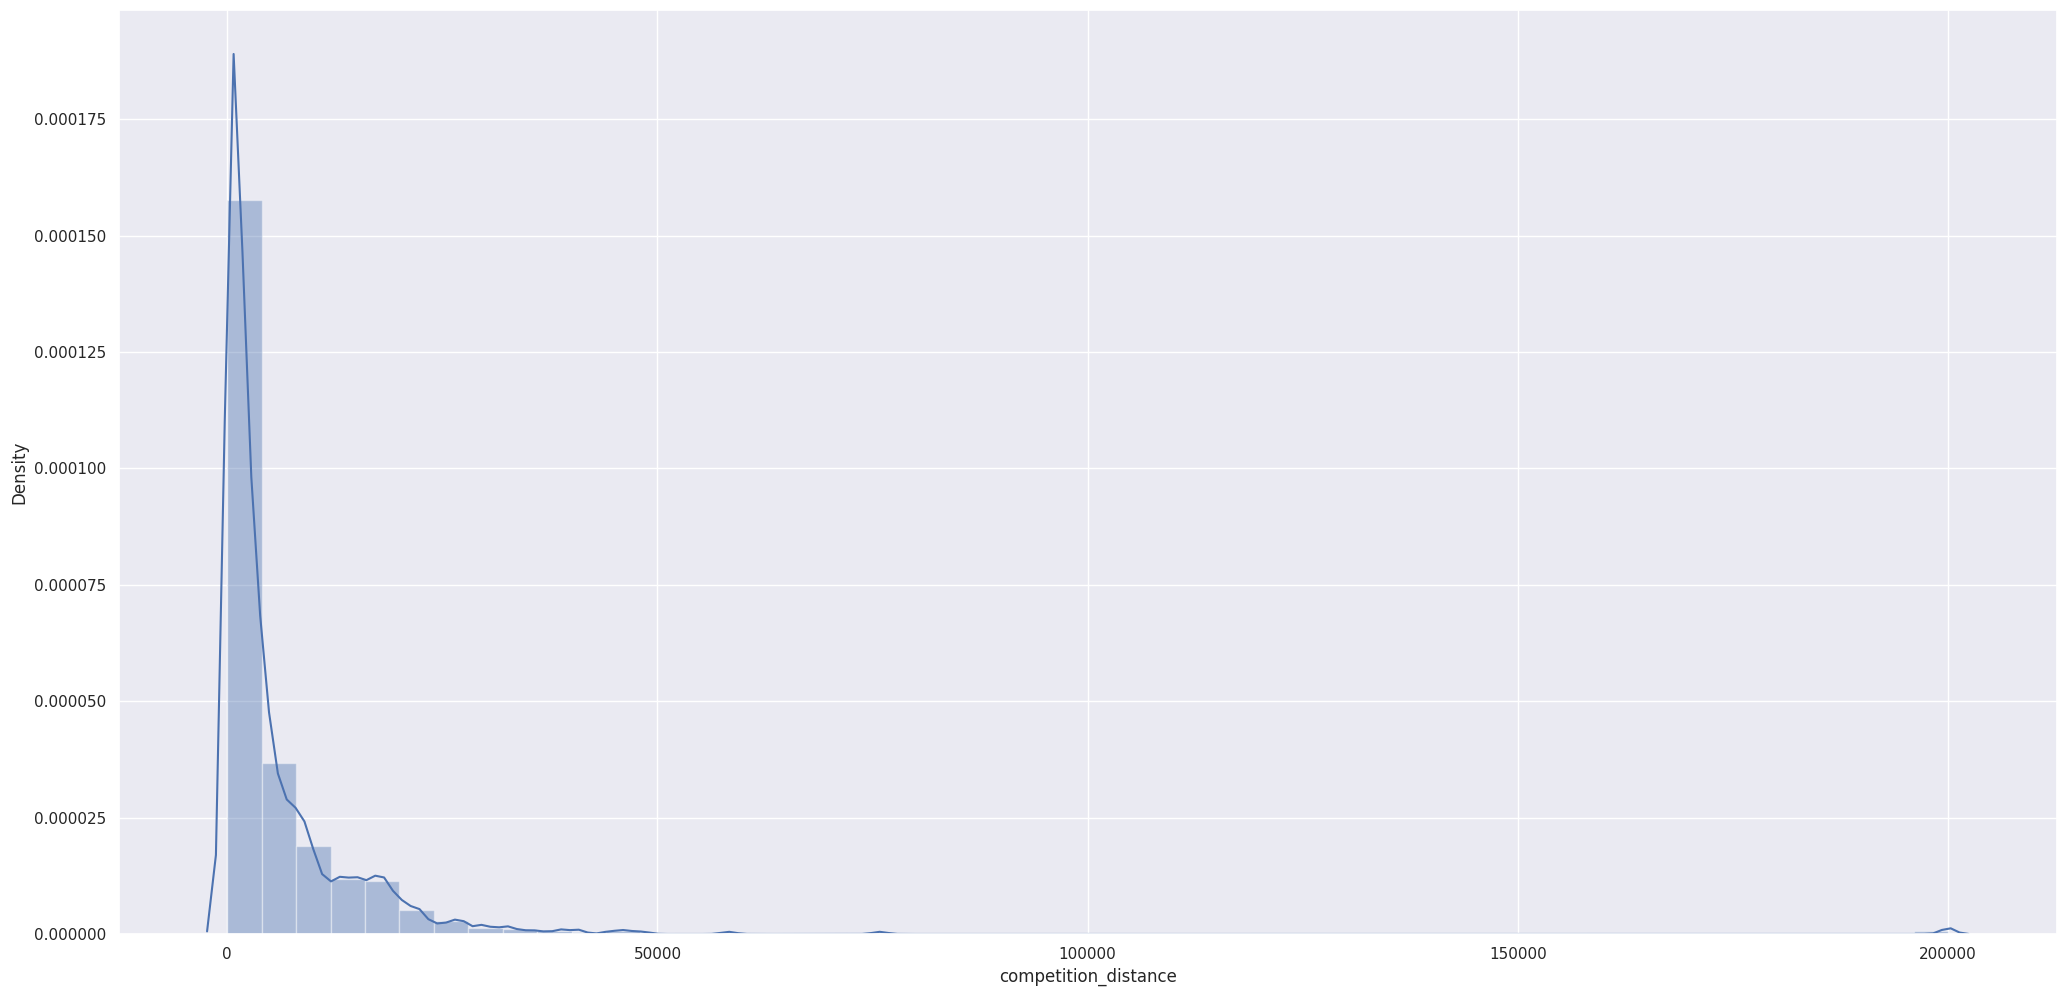

In [23]:
sns.distplot(df1['competition_distance']);

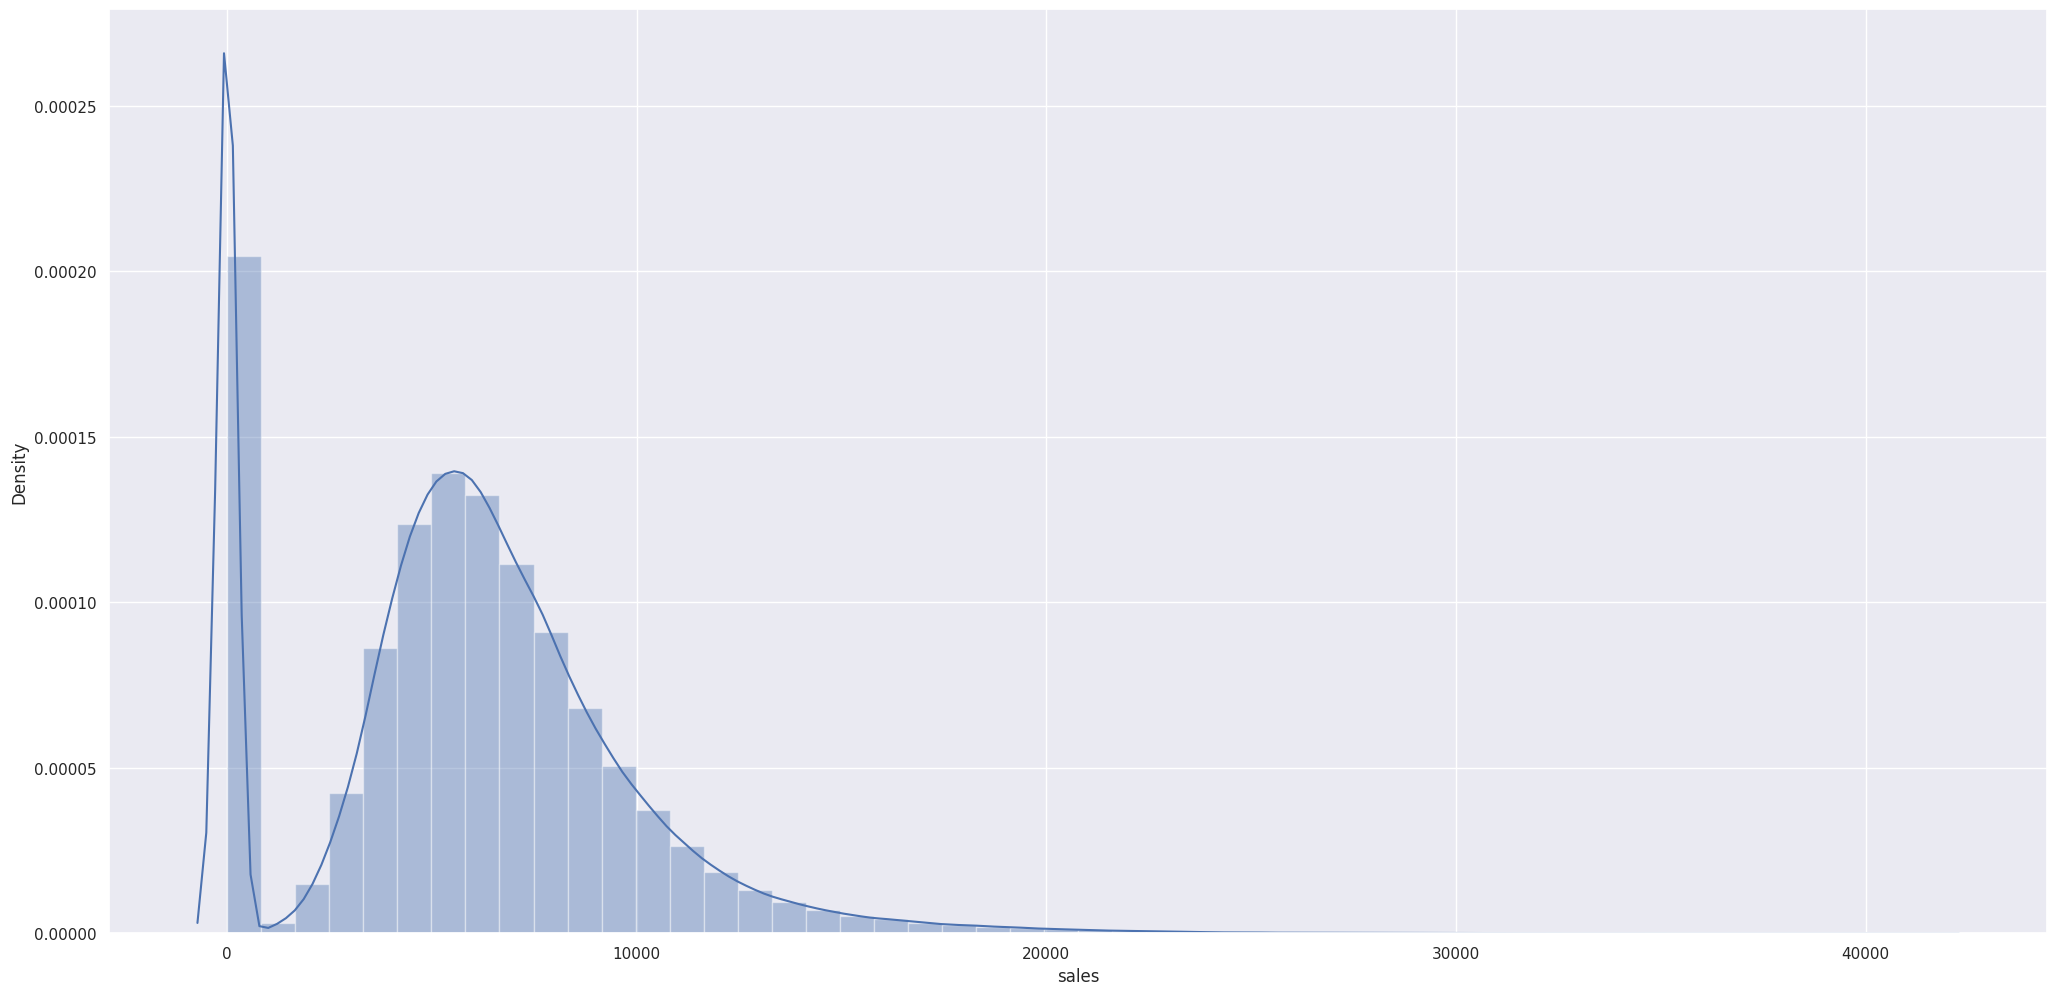

In [24]:
sns.distplot(df1['sales']);

### 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

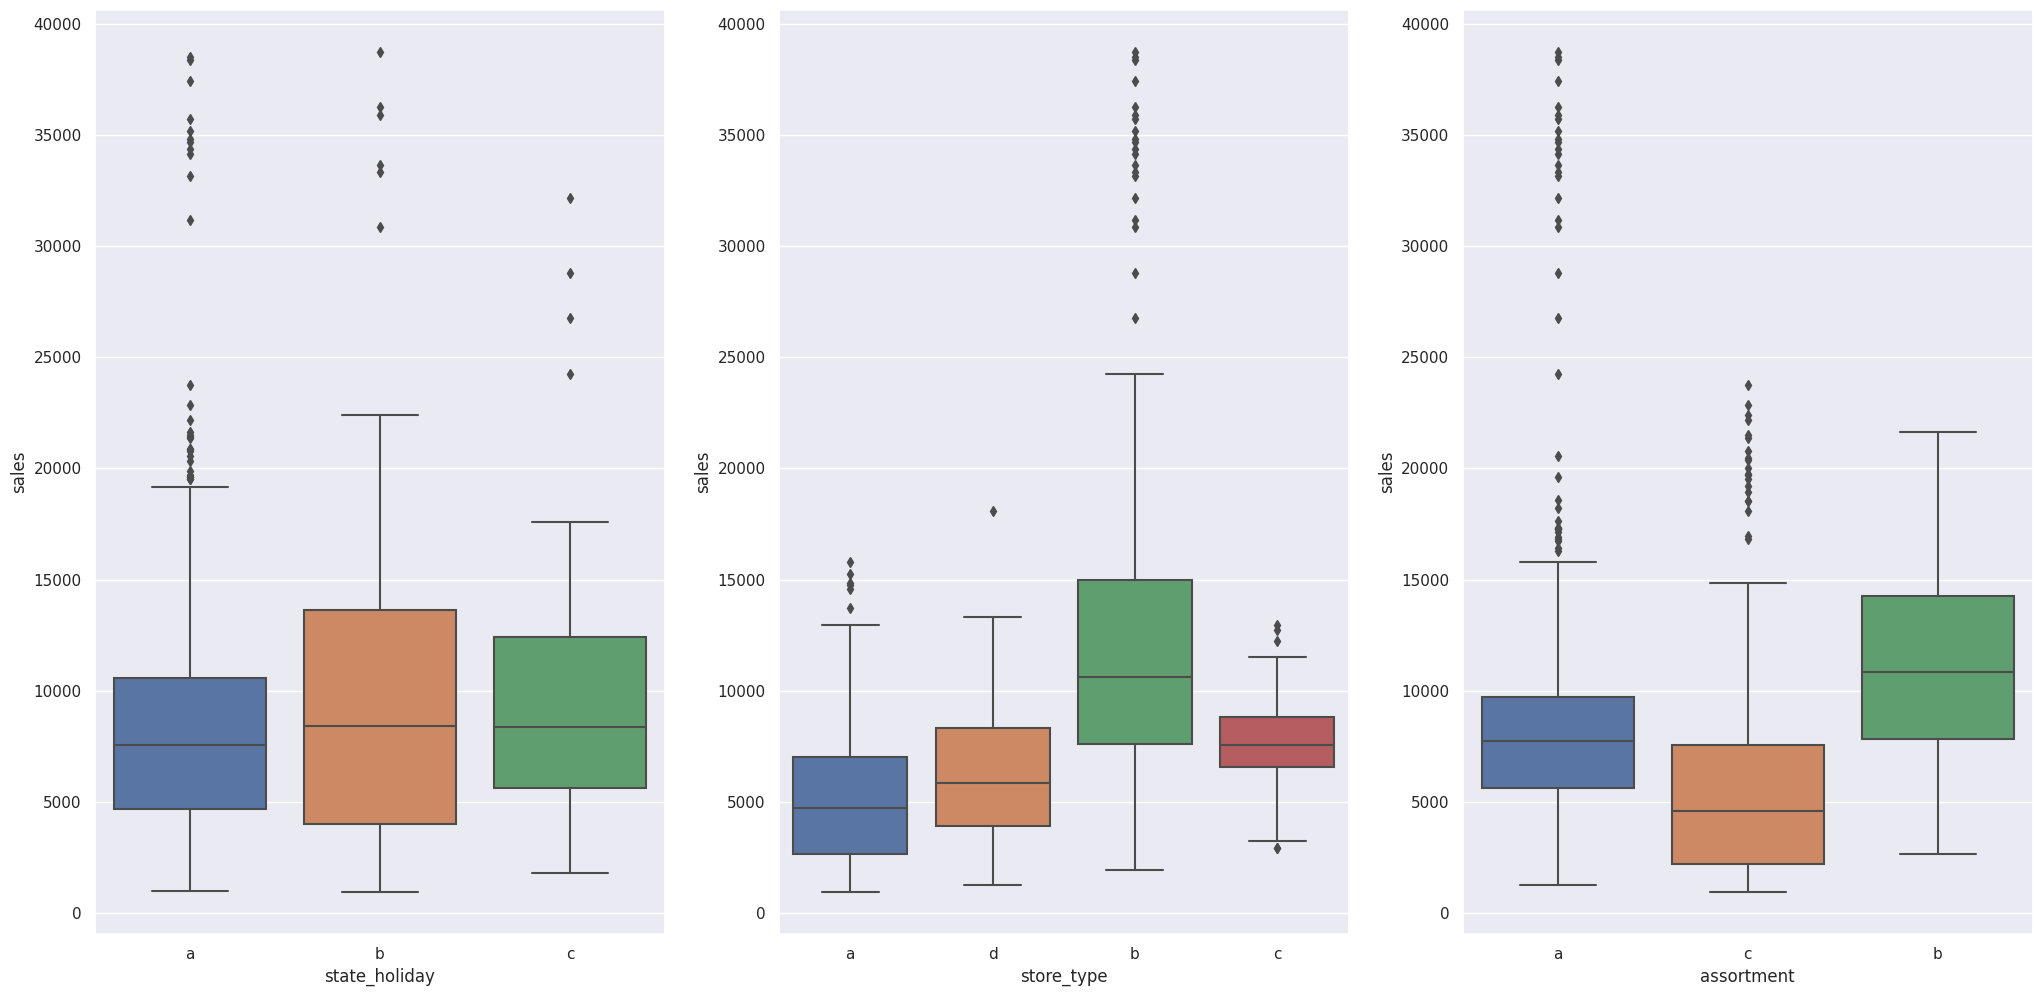

In [26]:
#Lets filter the days where the stores is closed
aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2.0 STEP 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mental map hypothesis

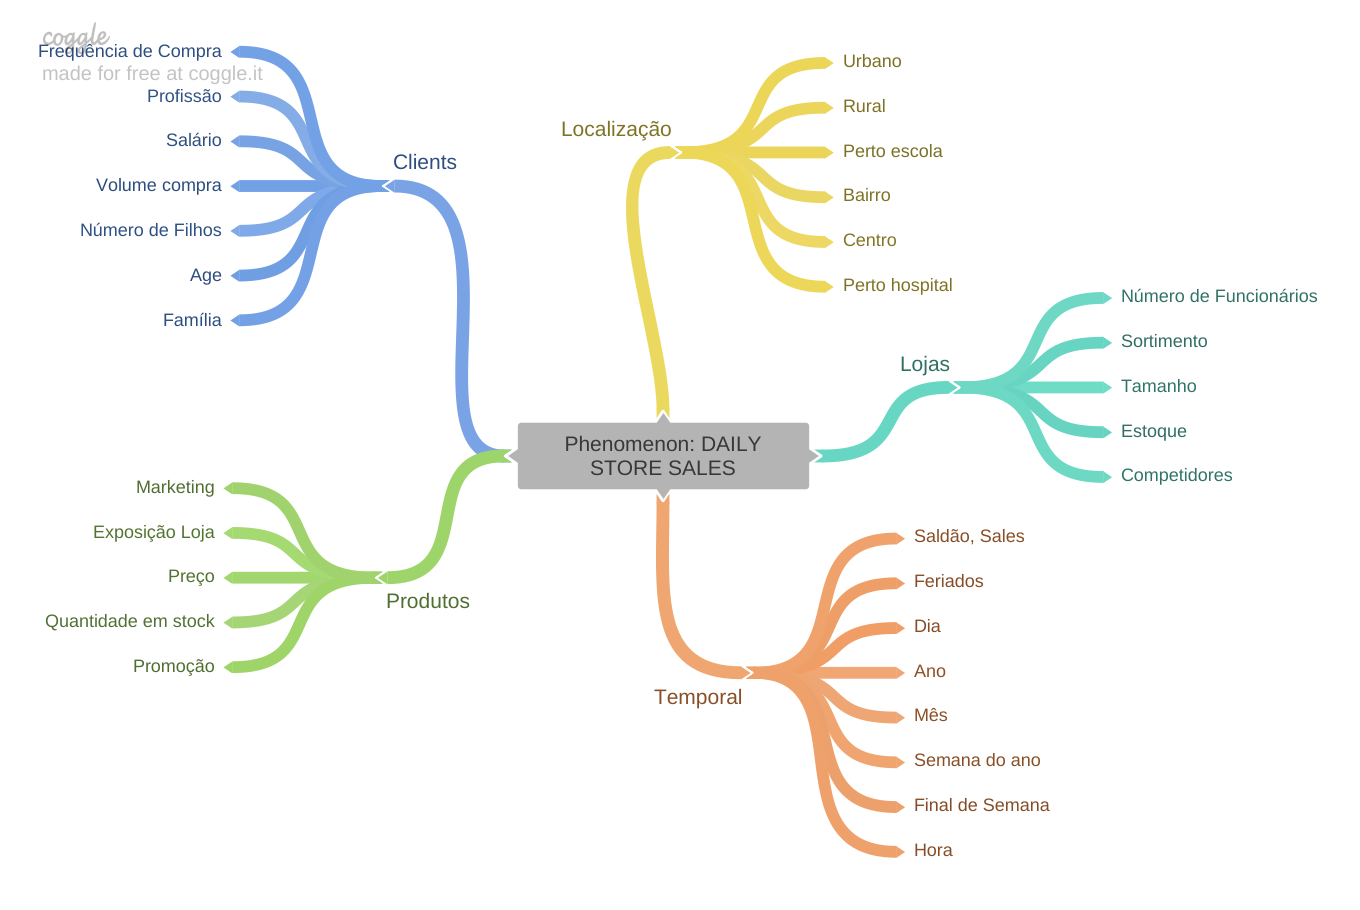

In [28]:
Image('img/mindmaphypotesis.png')

## 2.1  Creation of hypotheses

### 2.1.1 Store Hypothesys

**1.** Stores with larger staff sell more.

**2.** Stores with higher inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.1.2 Product Hypothesys

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that exposes more products in showcases should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with active promotions for longer should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.1.3 Time Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores were supposed to sell more in the second half of the year.

**4.** Stores were supposed to sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.2 Final list of hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores were supposed to sell more in the second half of the year.

**10.** Stores were supposed to sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.3 Feature Engineering

In [29]:
# Notes
# In competition_since the day is one why i'm considering that the competitor arrived on the first day of the month

# In competition_time_month i divided by 30 to maintain month granularity

# competition_time_month time of competition in months

# df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'))
# This command provides the first day of the week, depending on the number of the week and year indicated by the columns promo2_since_year and promo2_since_week. The '-1' in the lambda function is to get the first day of the week.
# - datetime.timedelta(days = 7)) removes 7 days to get the start of the promo

# promo_time_week -> number of weeks the store is in promotion

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day = 1), 
                                                                 axis = 1)
# divided by 30 to maintain the granularity of month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo2_year_week'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# # converting string to datetime
# df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
#                                              datetime.timedelta(days = 7))

# # extracting datetime in days
# df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' 
                                                if x == 'a' 
                                                else 'extra' 
                                                if x == 'b' 
                                                else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                  if x == 'a'  
                                                  else 'easter_holiday' 
                                                  if x == 'b' 
                                                  else 'christmas' 
                                                  if x == 'c'
                                                  else 'regular_day')

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


#  3.0 STEP 03 - FILTERING OF VARIABLES

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_year_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-31
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-13
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-14
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-31
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-31


## 3.1 Filtering of lines (reduce the amount of data)

In [34]:
# Notes:
# open -  if 0 the store is closed so 0 sales
# sales -  assume that if sales == 0, the store is closed

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column selection

In [36]:
# Notes:
# customers - we do not have the prediction of how many customers the store will have, so we aren't use it now
# open is only 1 now, promo interval and month map was used to derive another column

In [37]:
# cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
cols_drop = ['customers', 'open', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'is_promo',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo2_year_week'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df3.copy()

In [40]:
# updating with new features
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

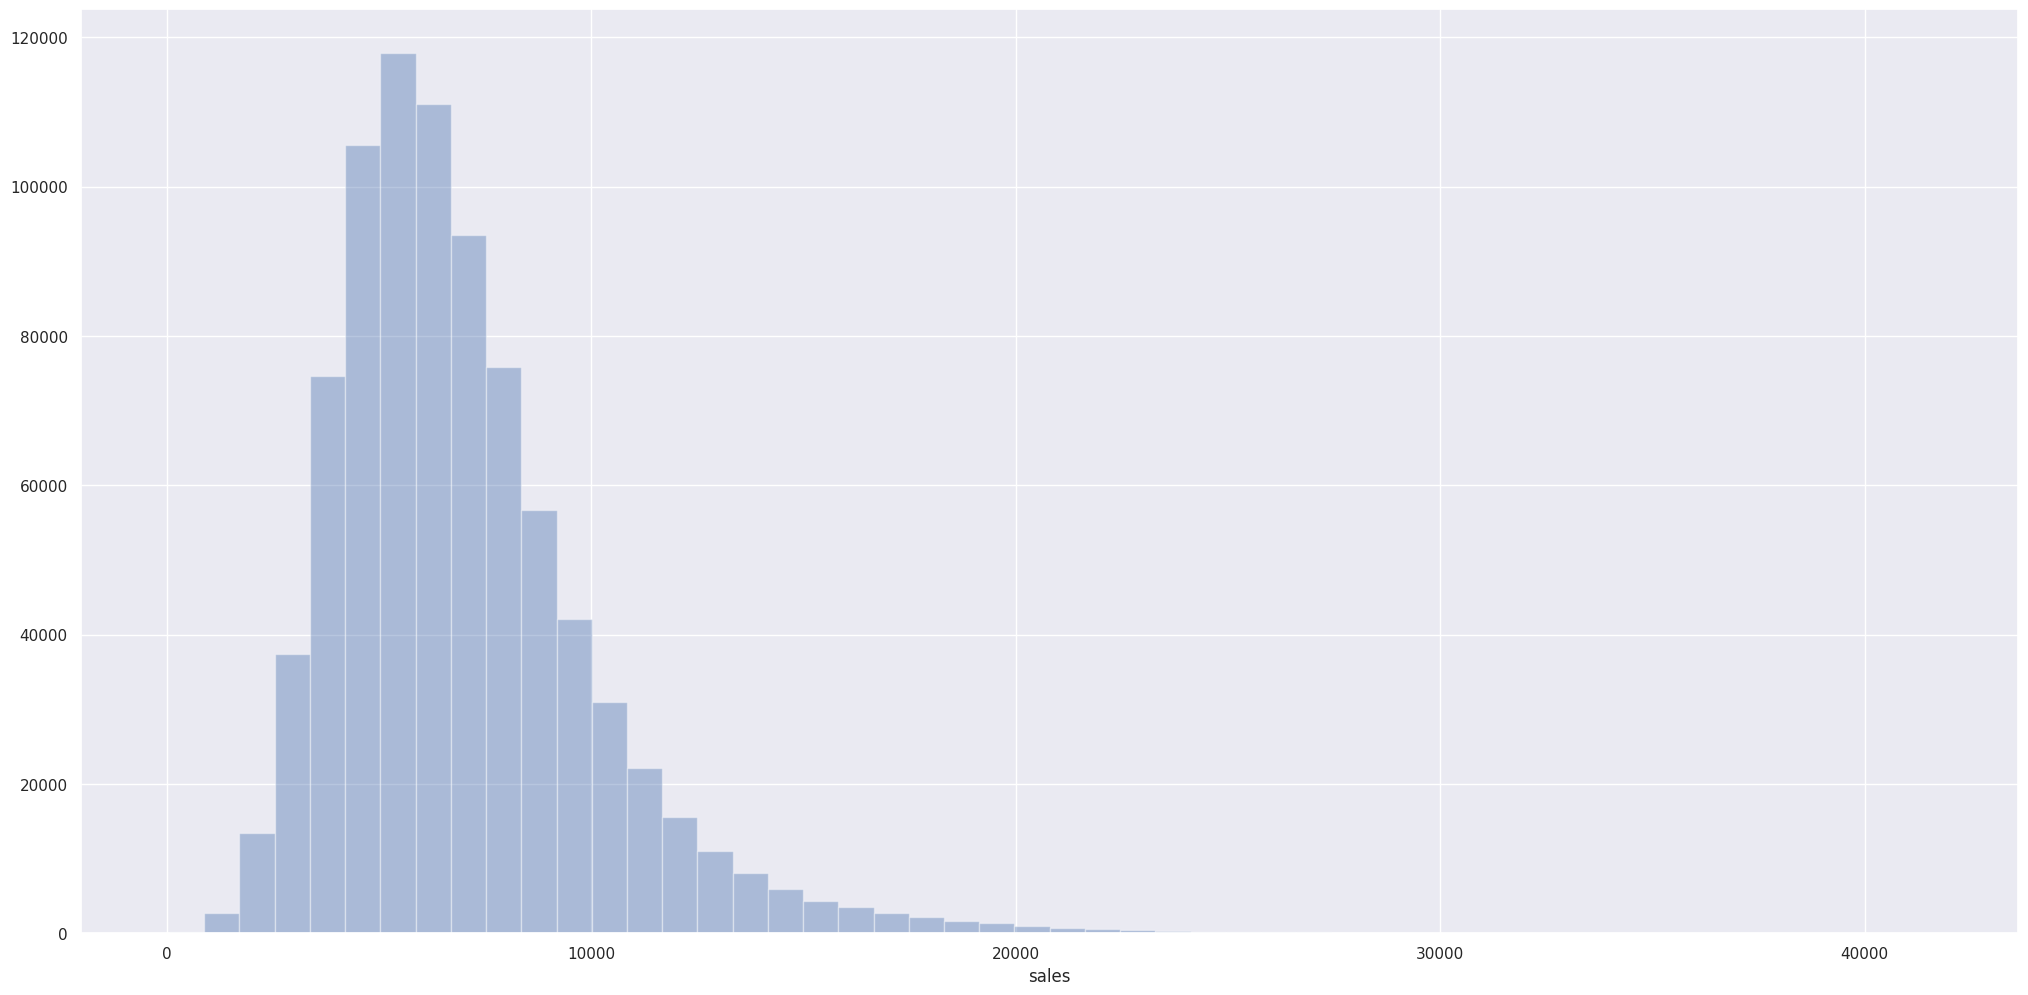

In [41]:
sns.distplot( df4['sales'], kde=False);

### 4.1.2 Numerical Variable

In [42]:
# Notes
# - store: the number of sales per store is well distributed.

# - day_of_week: the number of sales for each day of the week is well distributed, only day 7 that has a very small number of sales.

# - sales: has a slight positive skew, and there is a lot of sales worth 5000.

# - competition_distance: most competitors are less than 5000 meters away.

# - competition_open_since_month: The entry of new competitors happens more frequently in the 4th and 9th months, at the beginning of the year the number of new competitors is very small.

# - competition_open_since_year: from the year 2000 began to appear competitors and from the year 2015 there was a considerable increase in the amount of competitors.

# - promo2: the number of companies that participated in the extended promotion is practically the same as those of the companies that did not participate.

# - promo2_since_week: a significant number of stores began the promotion extended approximately in the 13th and 14th week of the year.

# - promo2_since_year: in 2013 and 2014, there were the largest numbers of extended promotions.

# - is_promo:the amount of sales made during the extended promotion period is not very significant.

# - year:the number of sales is decreasing since 2013.

# - month: most sales happen in the first 7 months.

# - day: the number of sales per day throughout the month is well distributed, with the exception of the first and the last where there is a slight decrease.

# - week_of_year: the largest number of sales happen during the first 31ths weeks

# - competition_time_month: most competitors opened approximately 16 months ago.

# - promo_time_week: most stores are not participating in the extended promotion.

In [43]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'competition_time_month'],
      dtype='object')

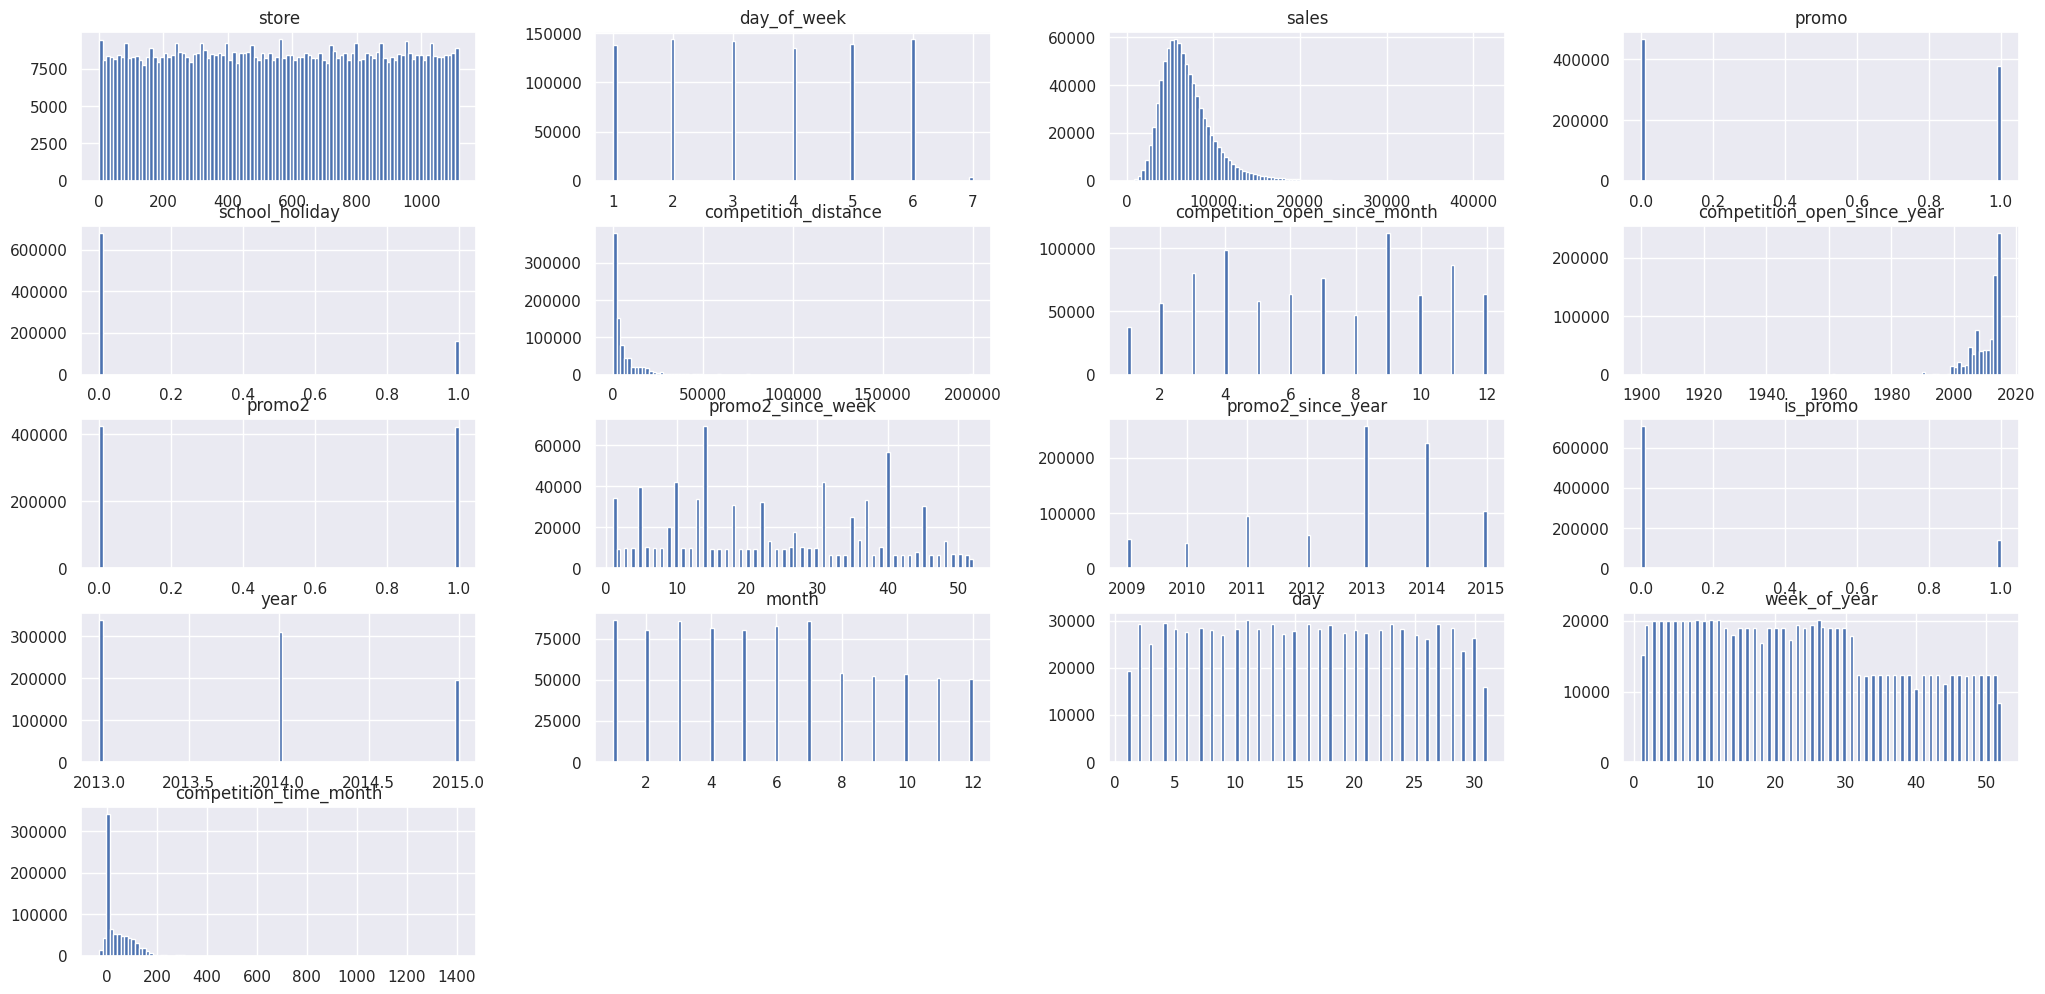

In [44]:
num_attributes.hist(bins=100);

### 4.1.3 Categorical Variable

In [45]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'year_week', 'promo2_year_week'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


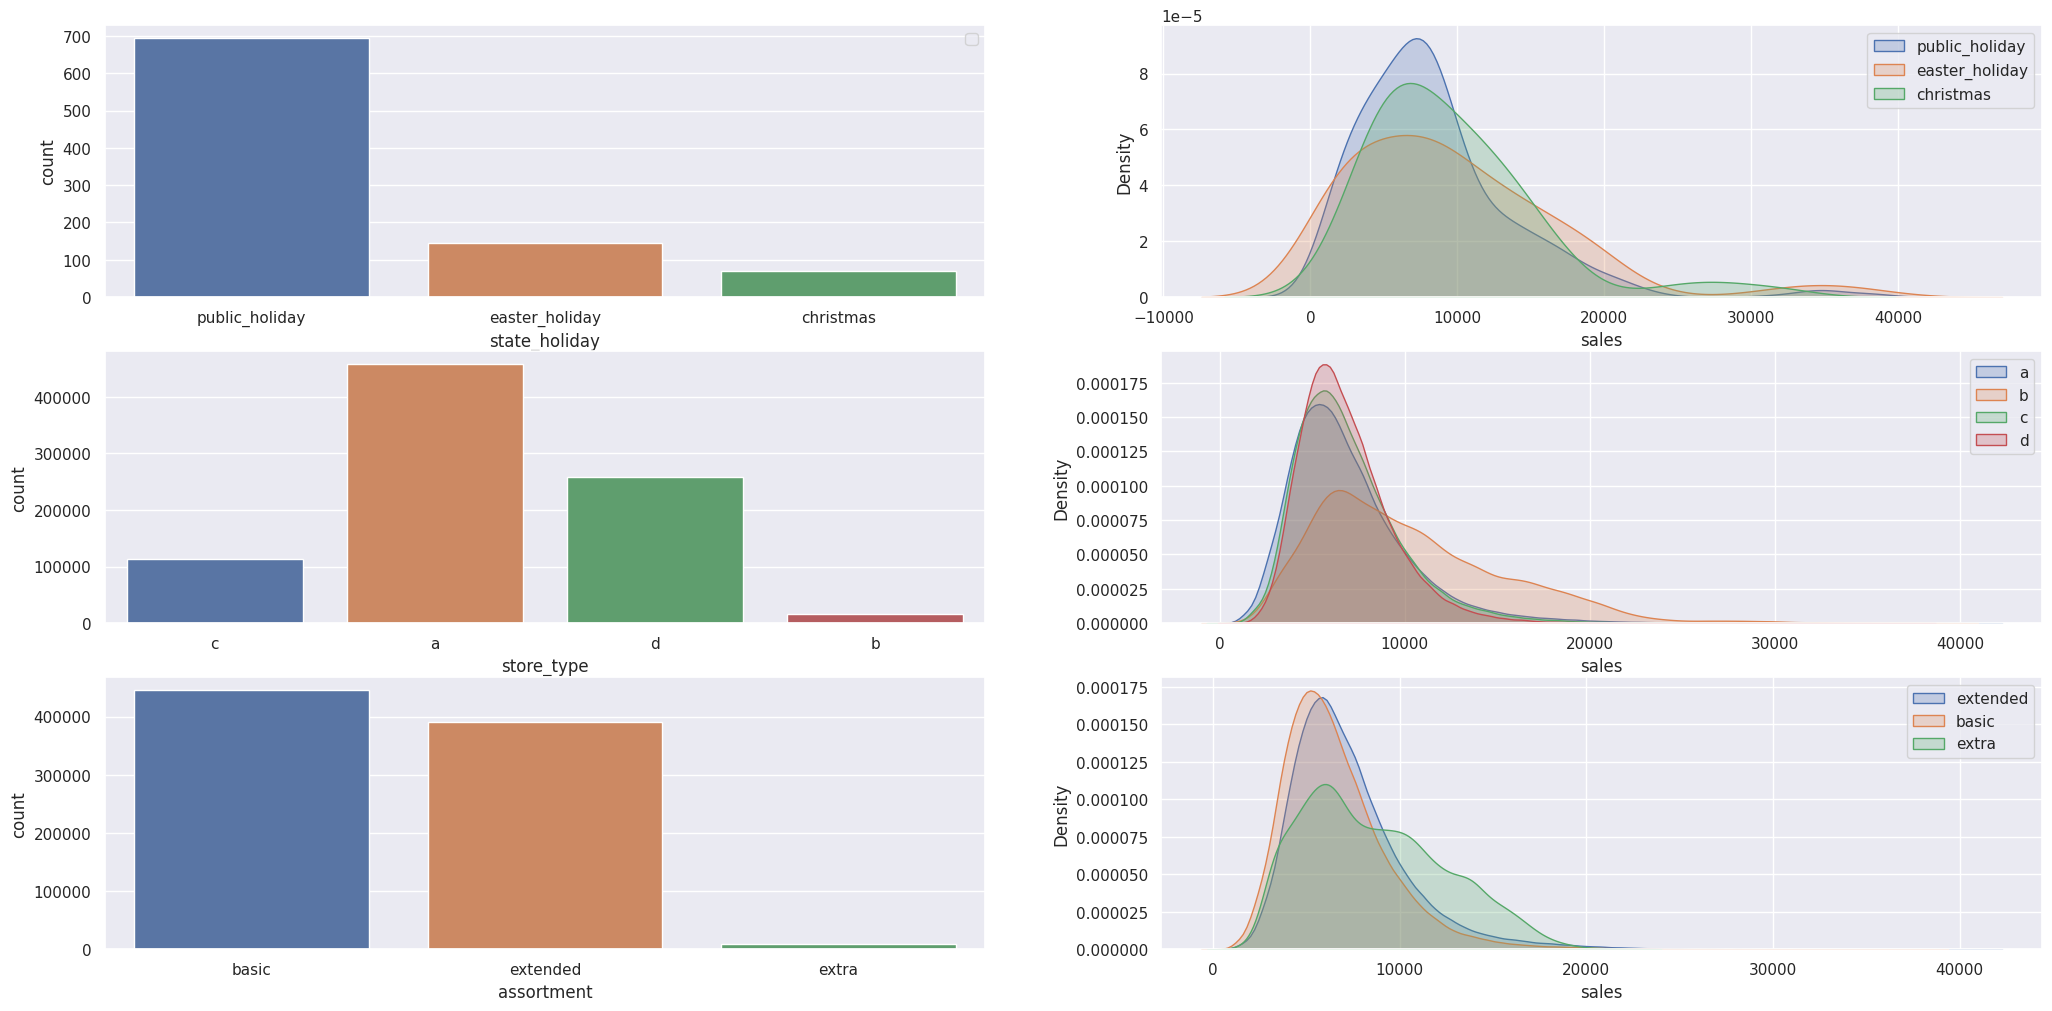

In [46]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'])
legend(loc="upper right")

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday', shade=True)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],     label = 'christmas', shade=True)
ax.legend(loc="upper right")

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
ax = sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
ax.legend(loc="upper right")

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],    label = 'basic', shade=True)
ax = sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],    label = 'extra', shade=True)
ax.legend(loc="upper right")

## 4.2. Bivariate Analysis

### H1. Stores with more assortments should sell more.

### FALSE Stores with MORE ASSORTMENT sell LESS.

In [47]:
# Notes:
# - Assuming that the extra assortment is greater than the extended, and the extended is greater than the basic.

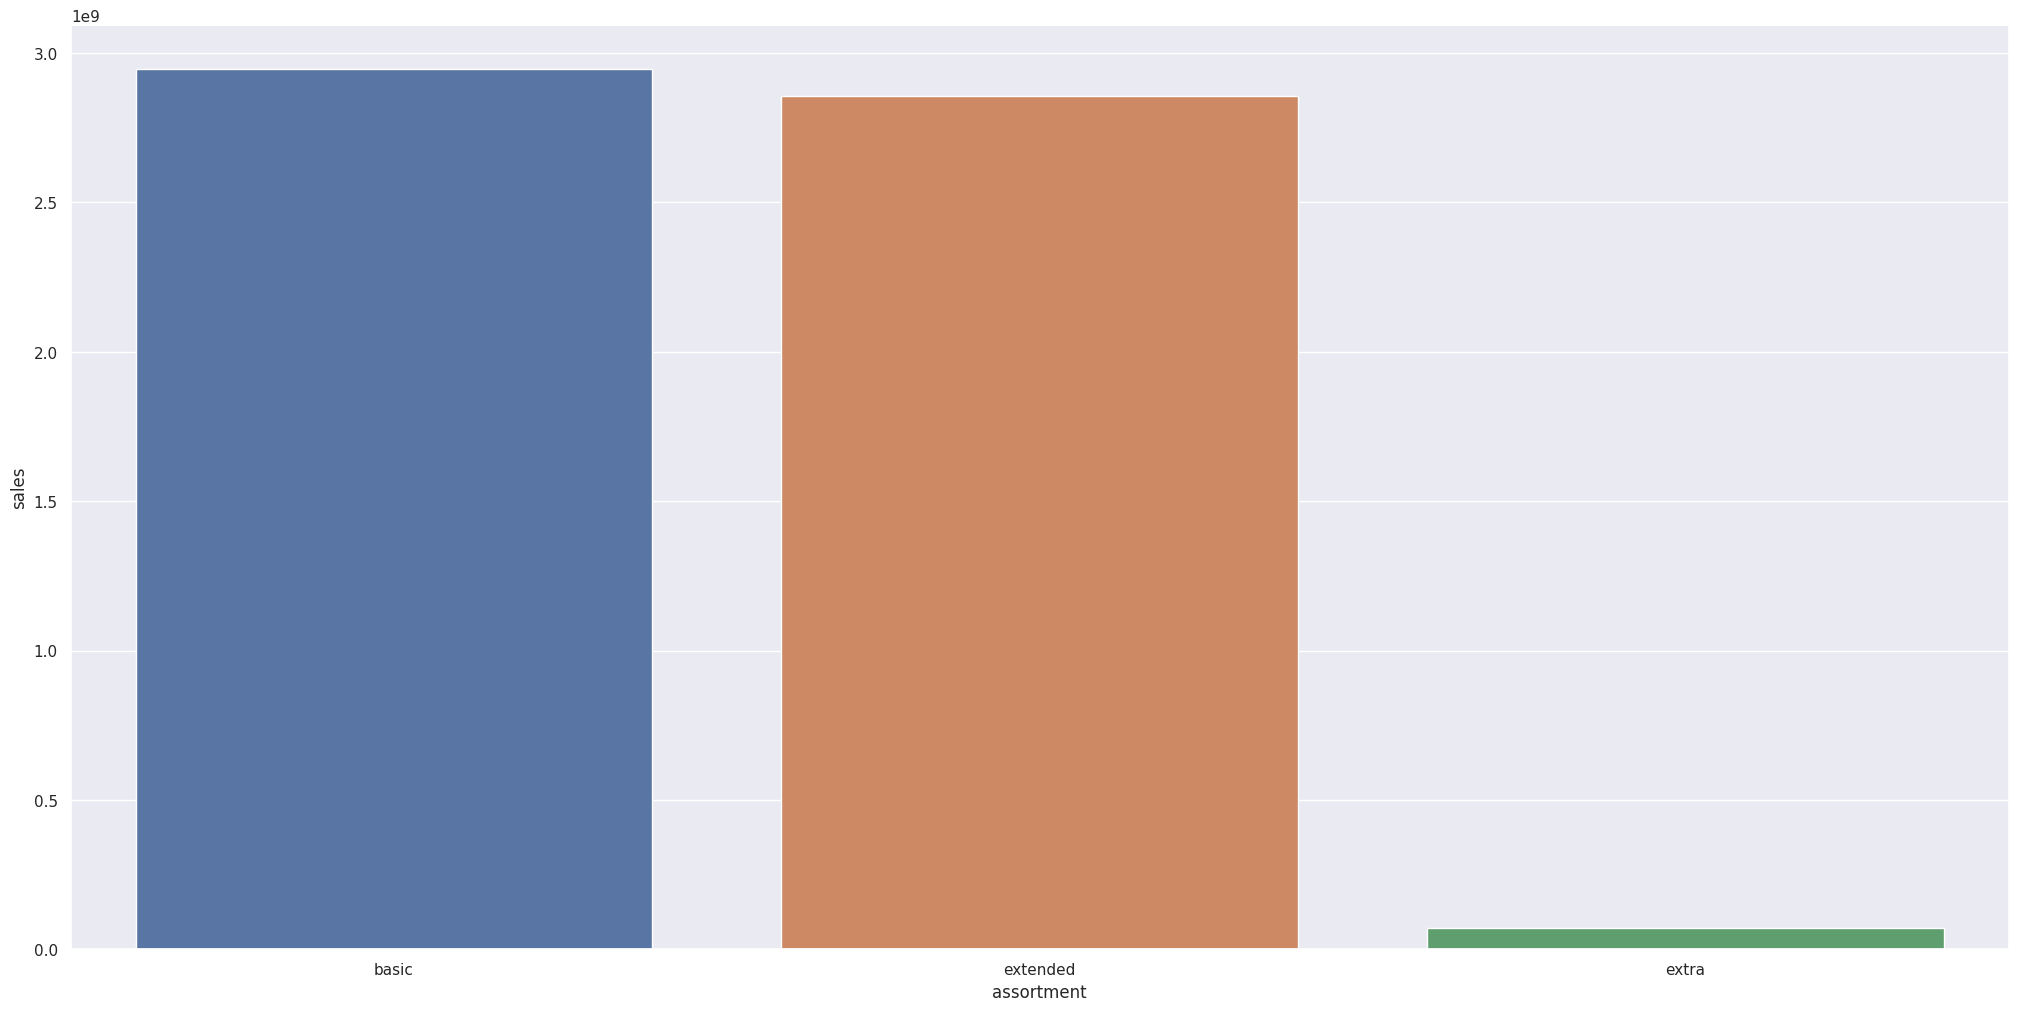

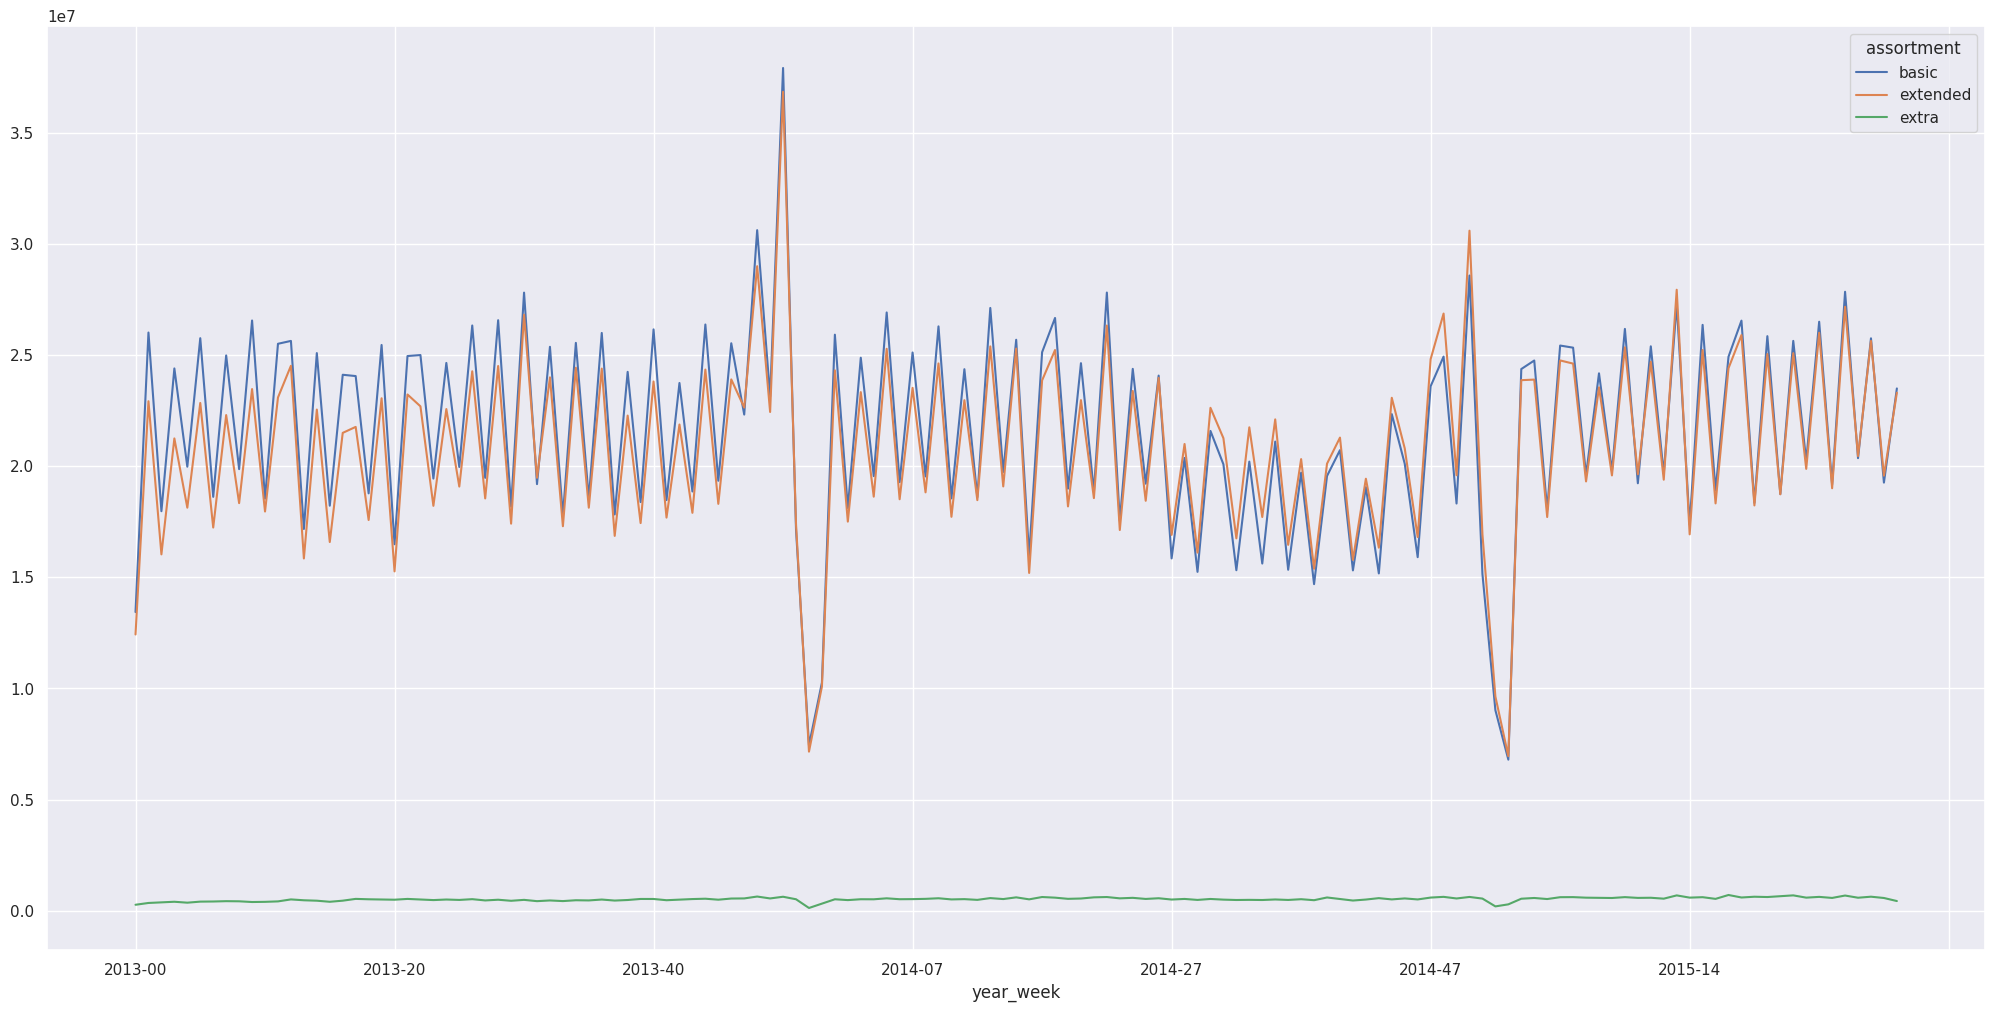

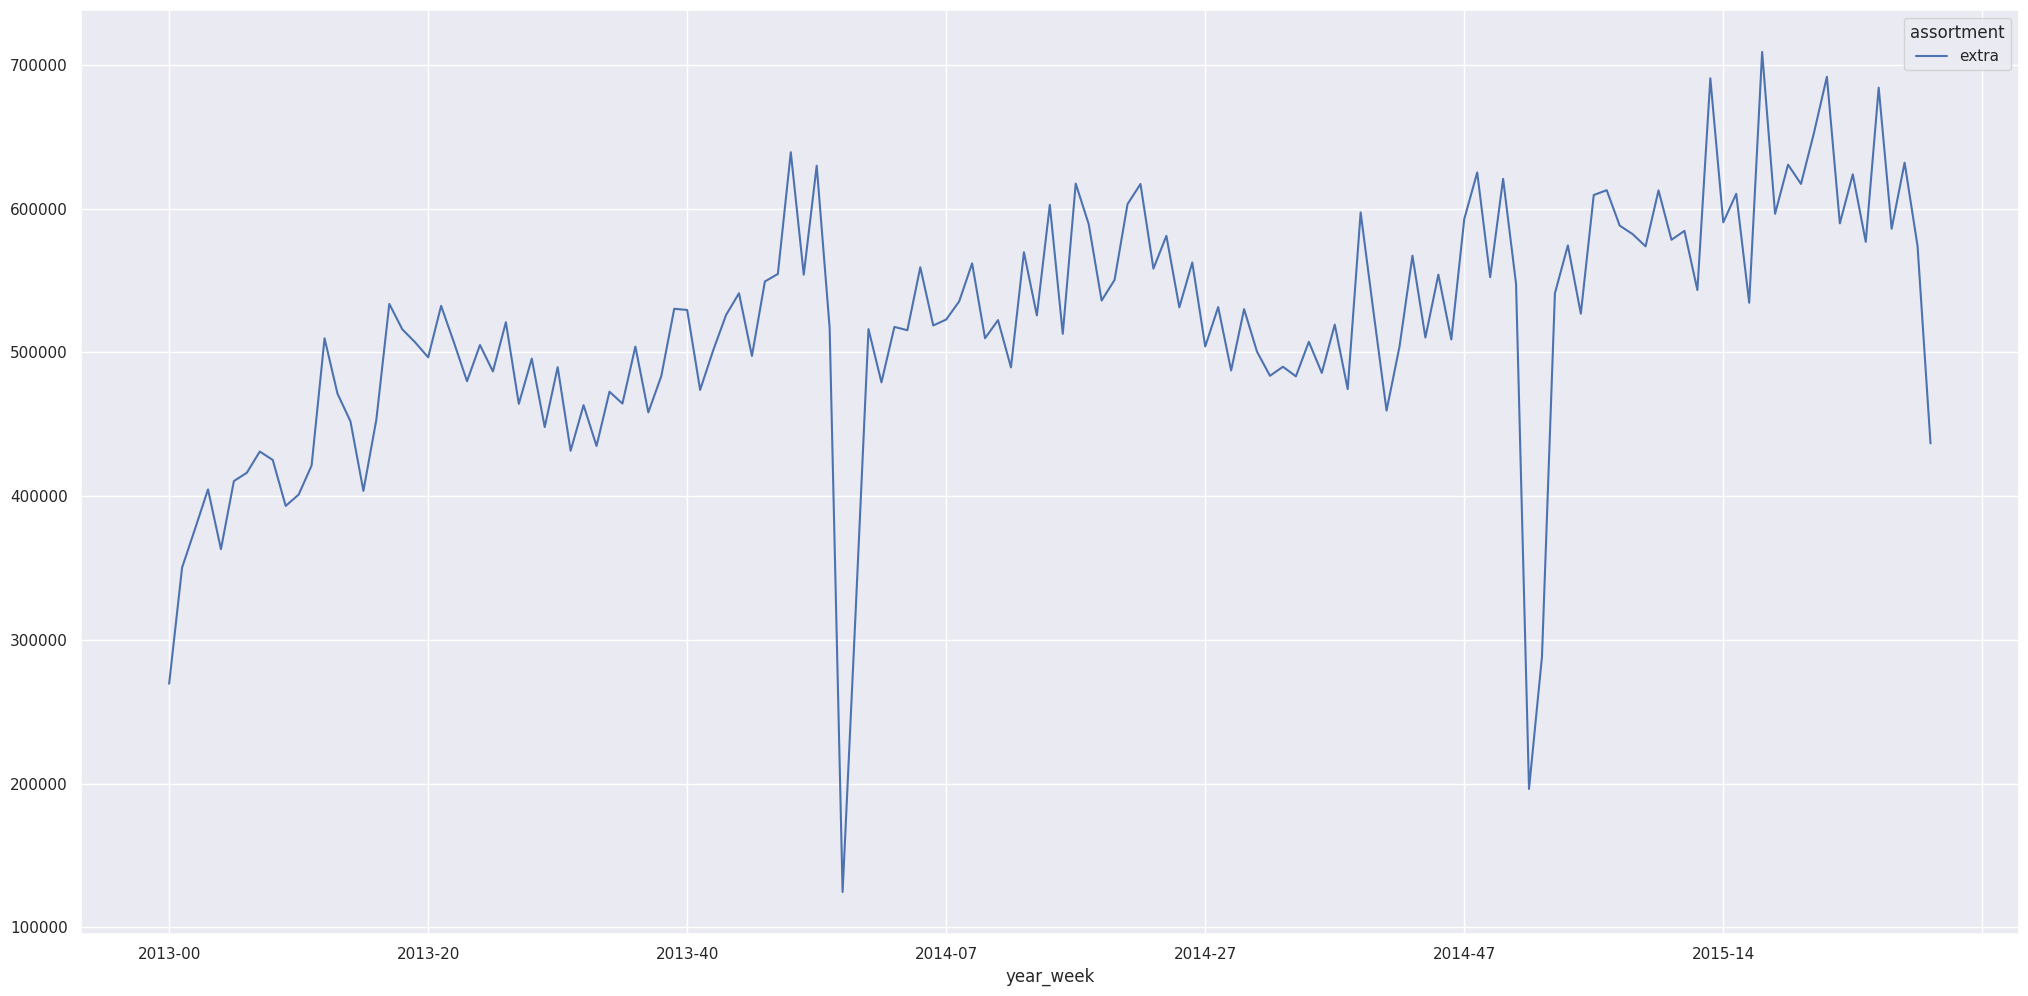

In [48]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Stores with closer competitors should sell less.

### FALSE Stores with MORE CLOSE competitors sell MORE.

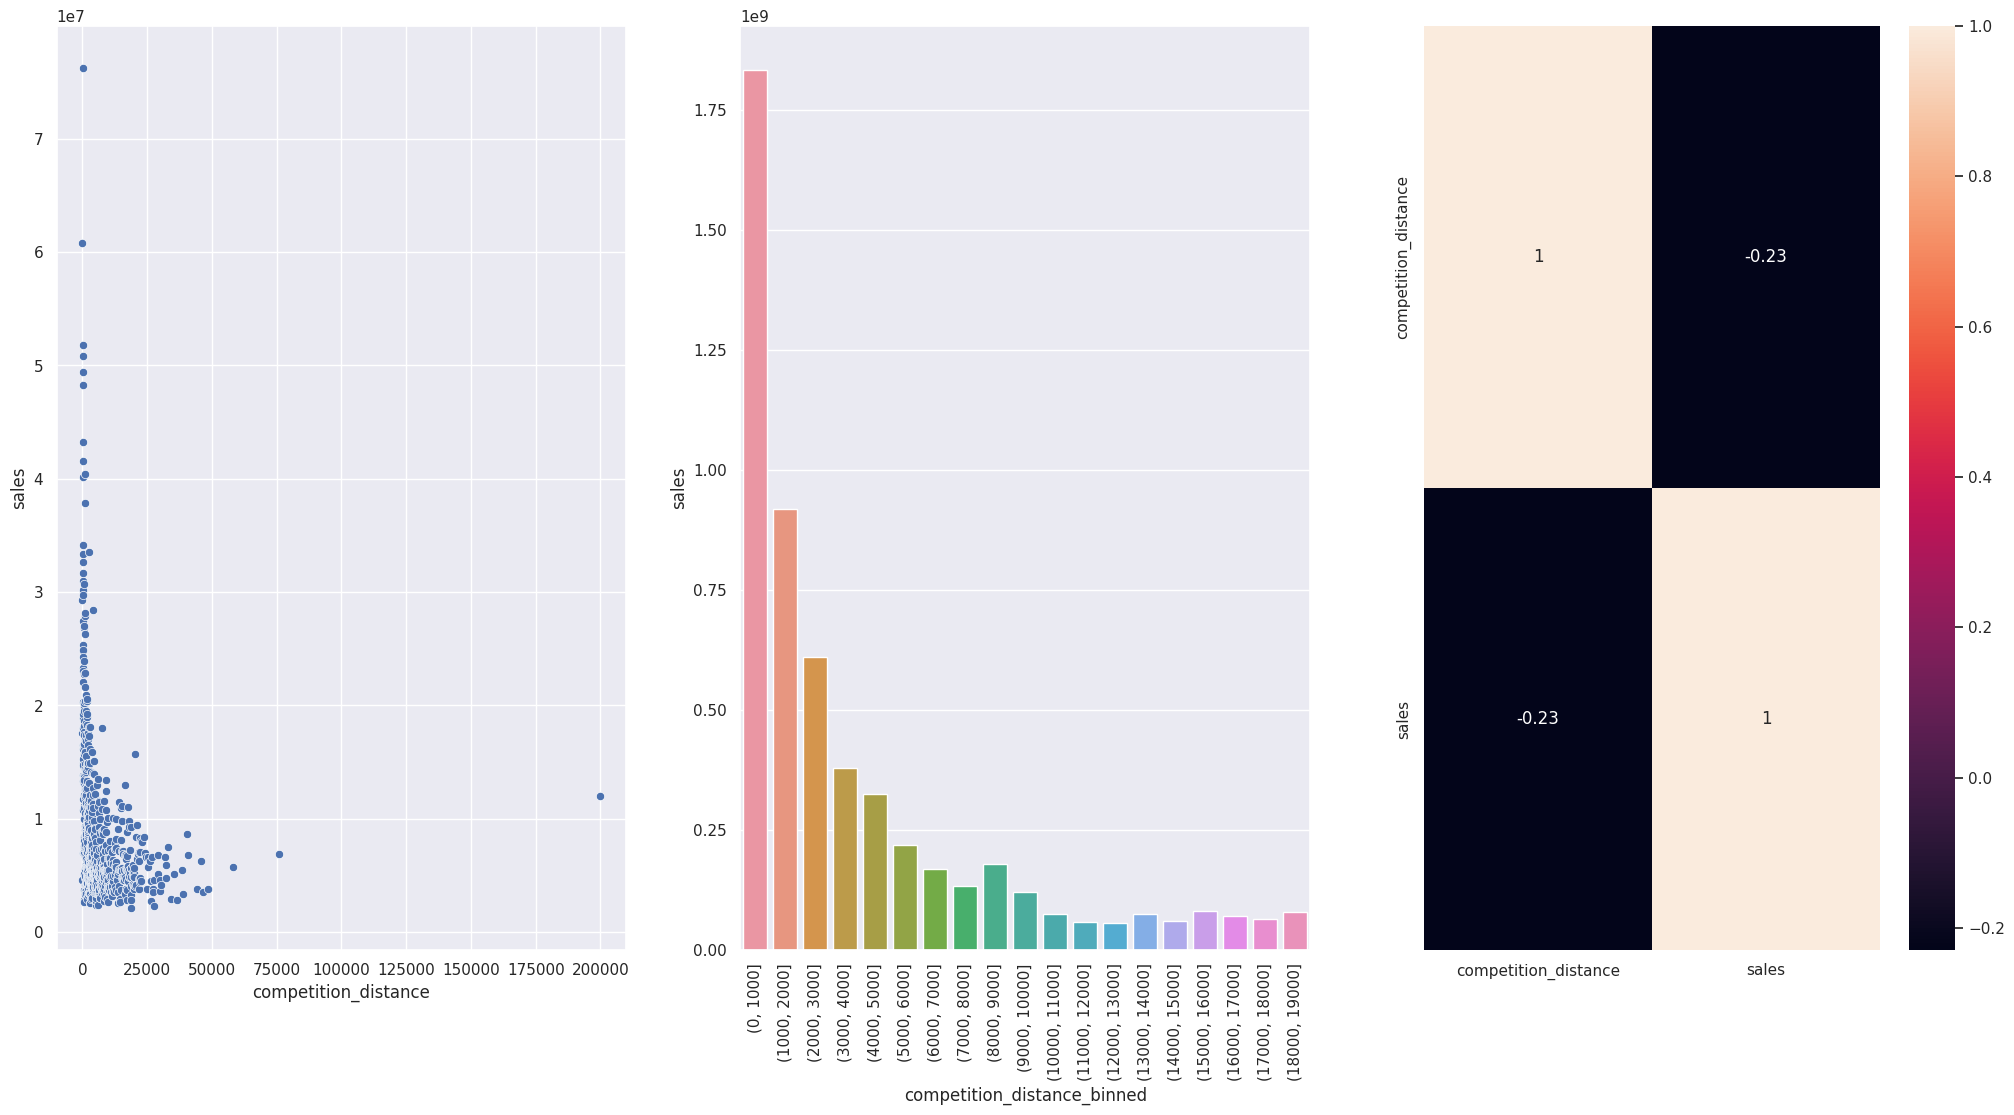

In [49]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores with old competitors should sell more.

### FALSE Stores with Older Competitors Sell LESS.

In [50]:
# Note
# the negative values are from competitors who would still inaugurate, so the current date is lower. It is possible to conclude that the more recent the competitive opening the more sales are made.

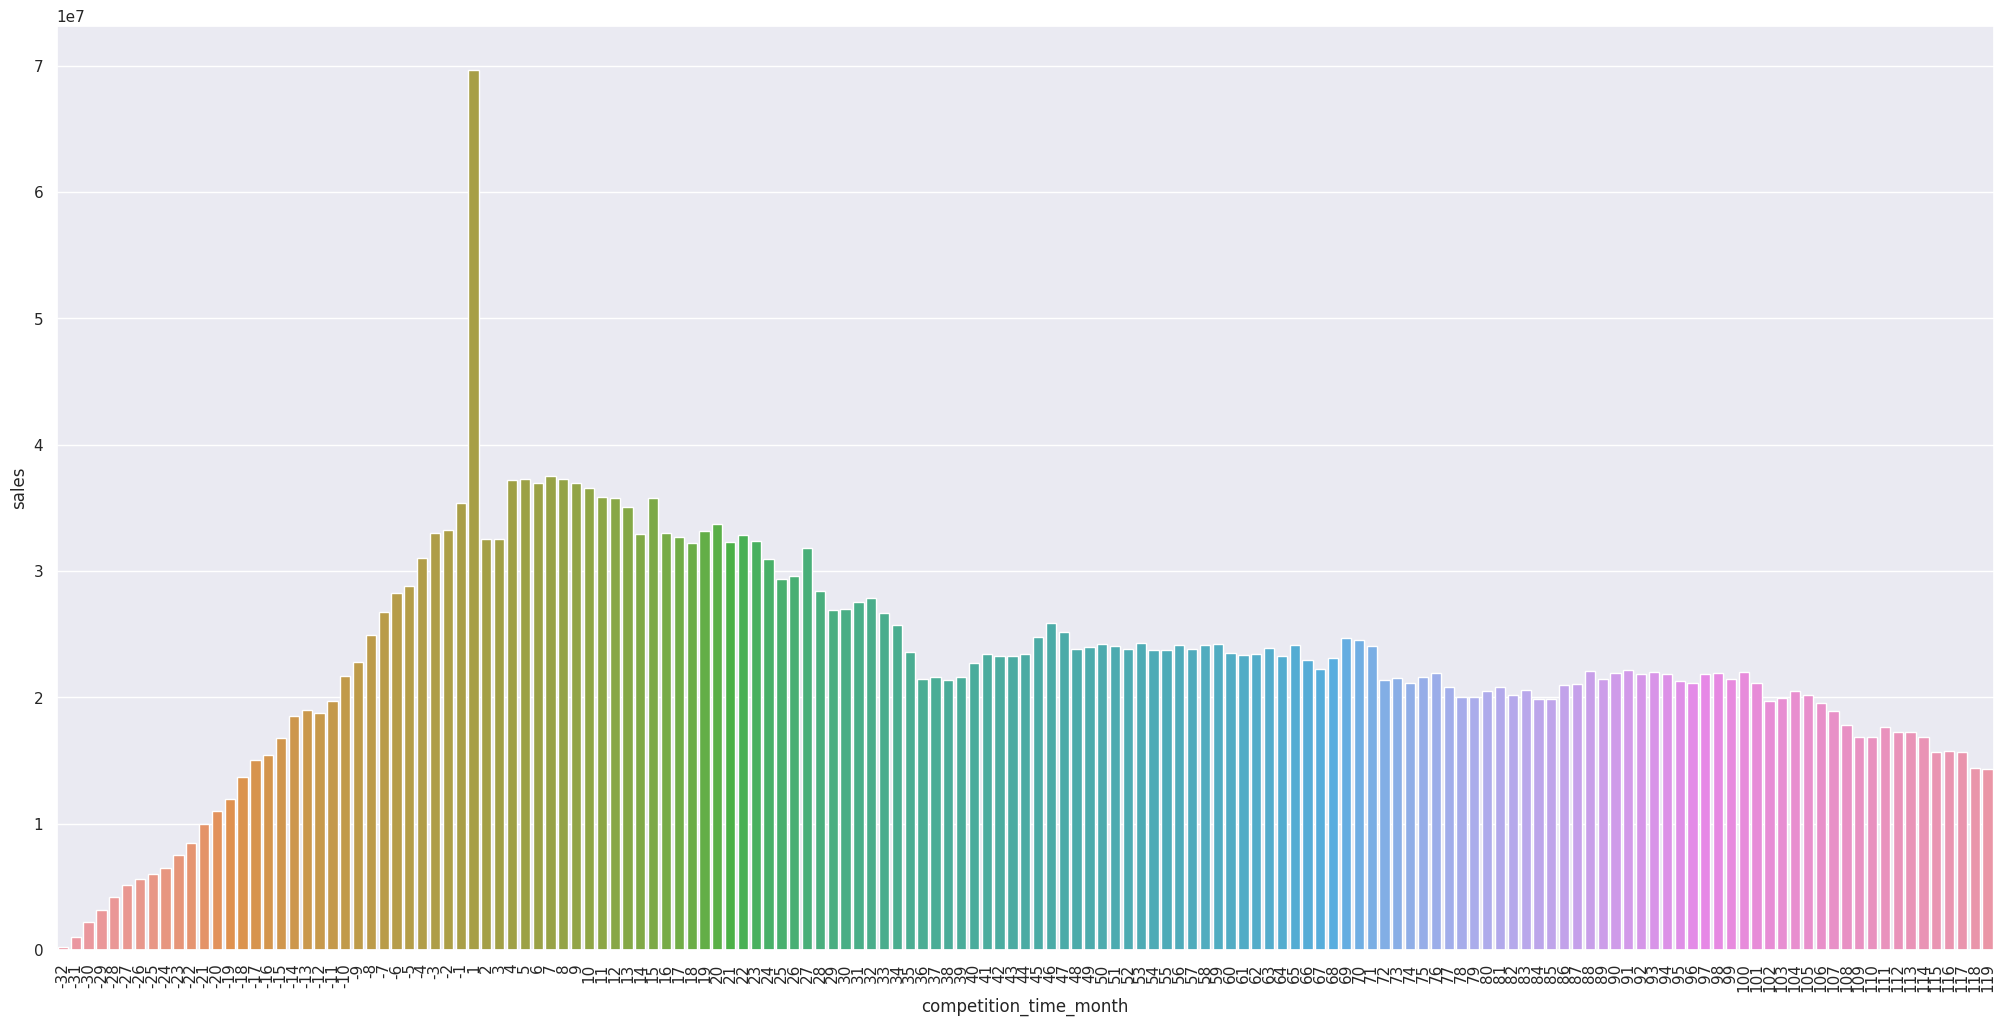

In [51]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

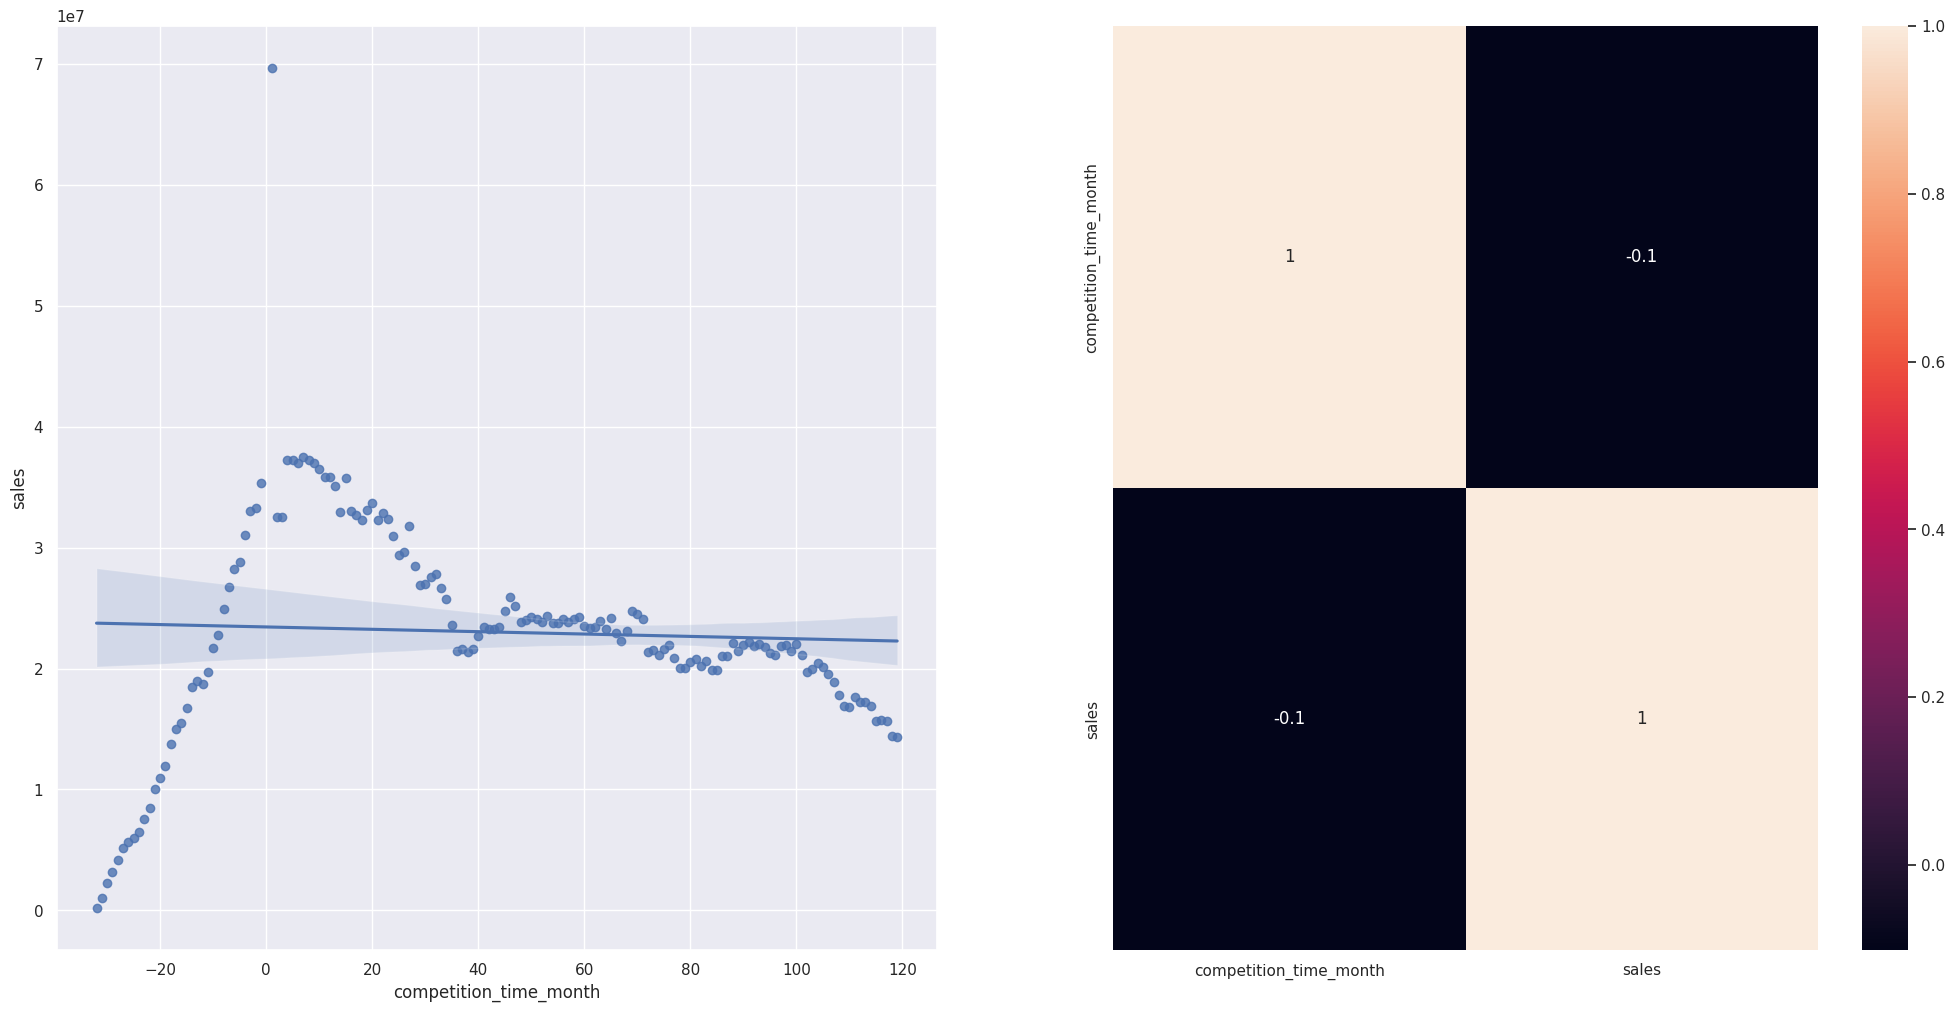

In [52]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 2, 2)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Stores with active promotions (promo) should sell more.
### TRUE Stores with active promotions (promo) should sell more.

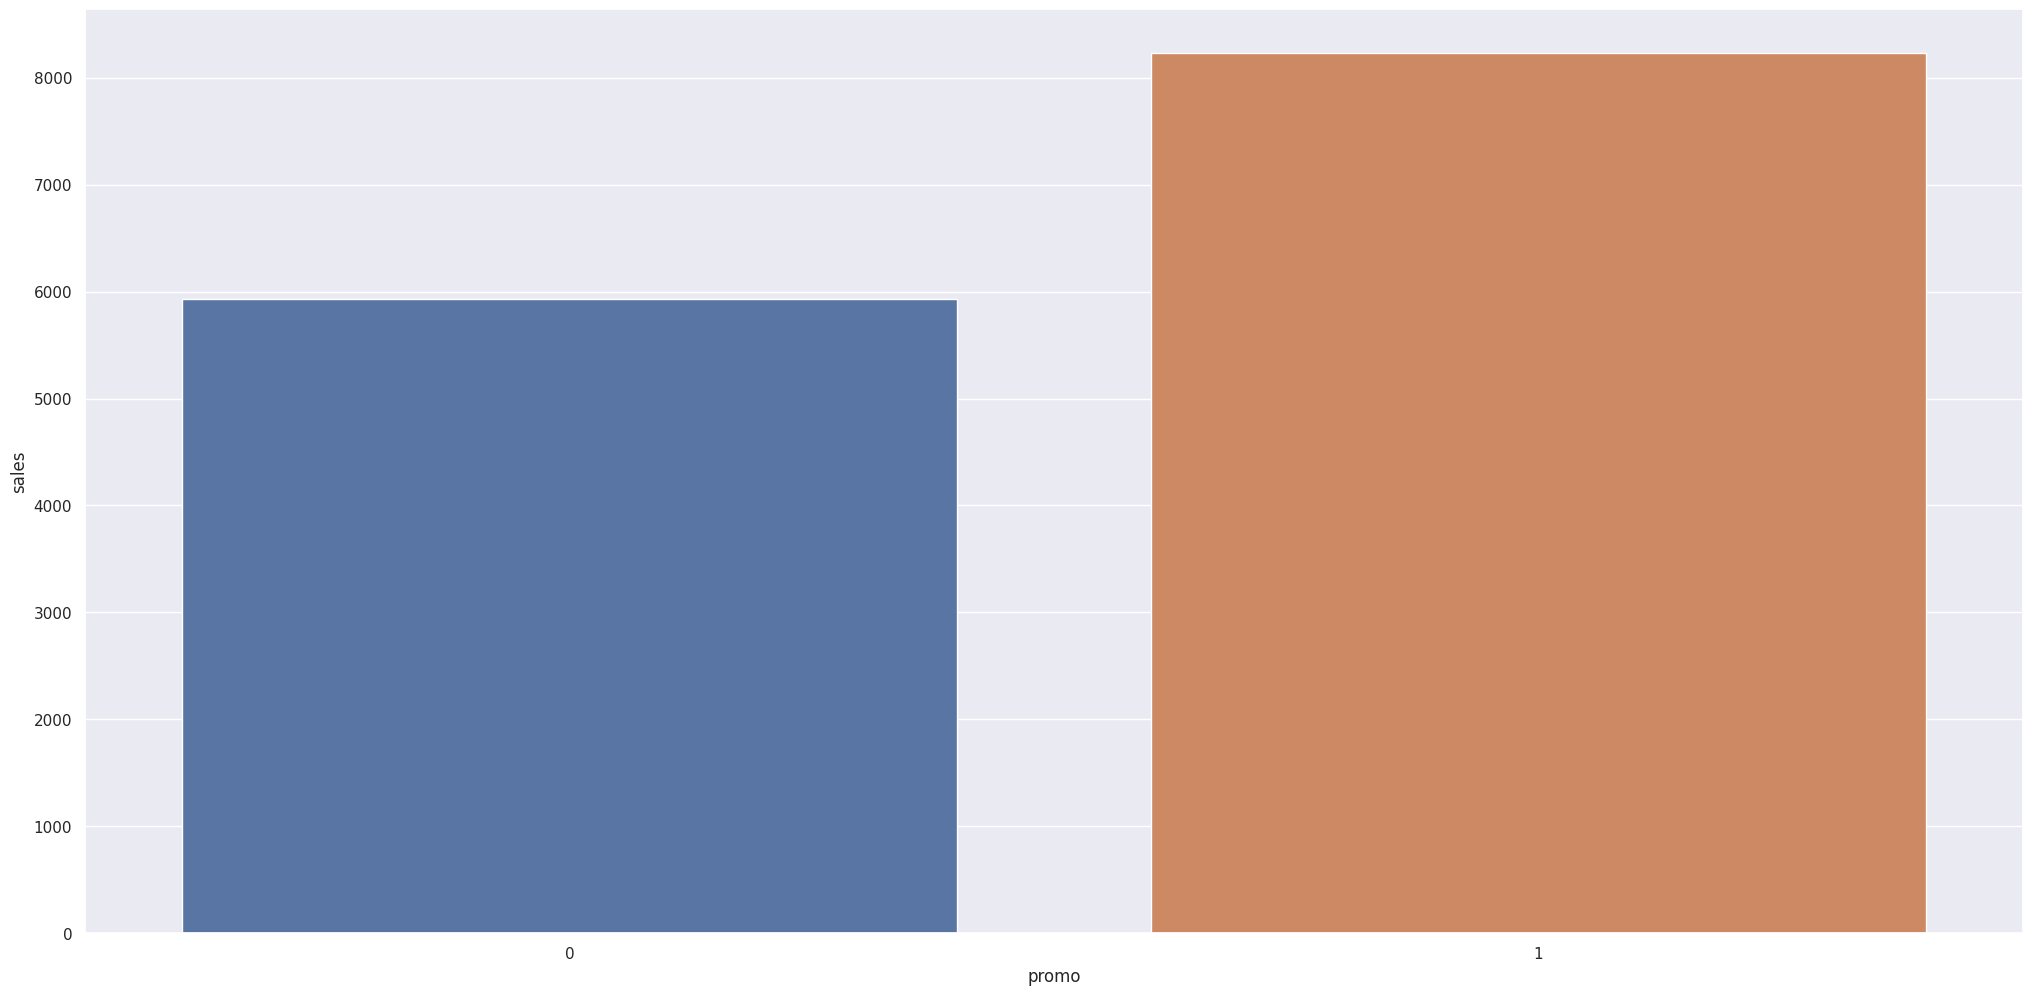

In [53]:
aux = df4[['promo', 'sales']].groupby('promo').mean().reset_index()
sns.barplot(x = 'promo', y = 'sales', data = aux);

### H5. Stores with active promotions (promo2) should sell more.

### FALSE Stores with active promotions (promo2) sell less.

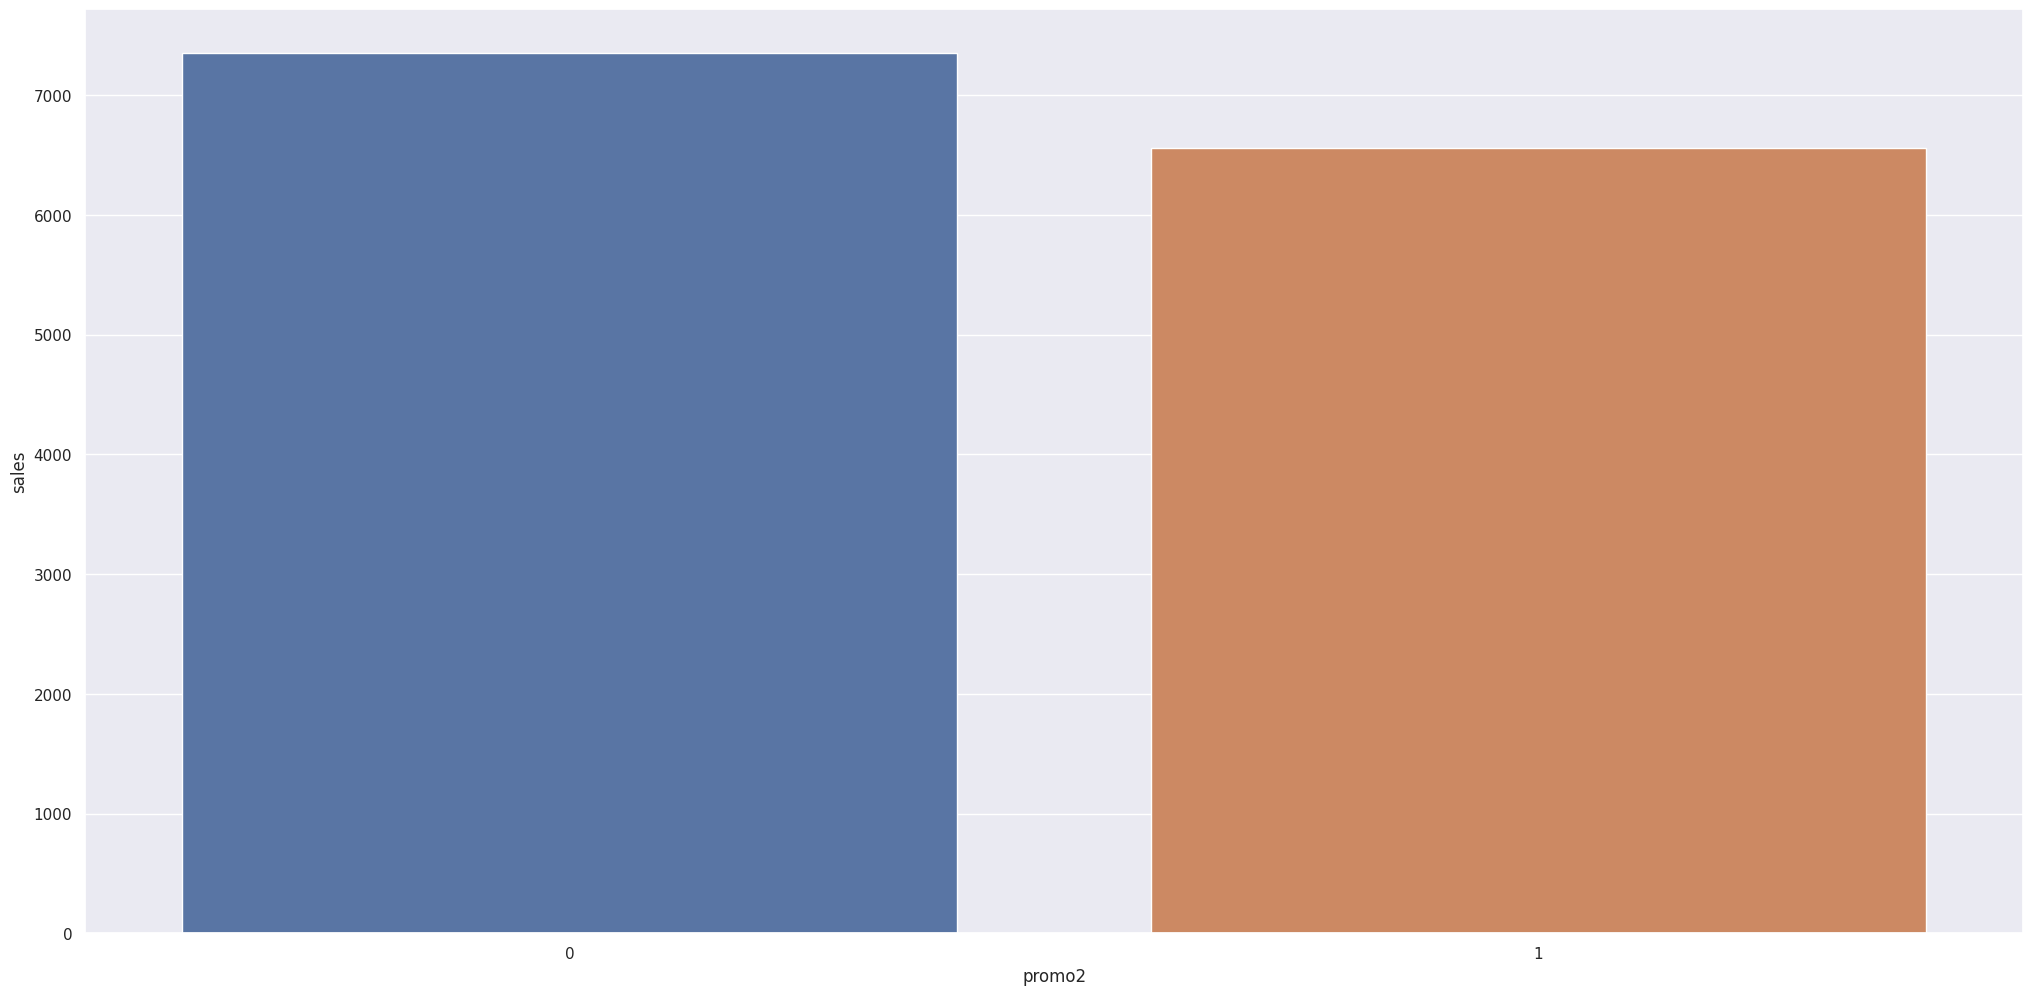

In [54]:
aux = df4[['promo2', 'sales']].groupby('promo2').mean().reset_index()
sns.barplot(x = 'promo2', y = 'sales', data = aux);

### H6. Stores with active promotions (promo2 and promo) should sell more.

### FALSE Stores with active promotions (promo2 and promo) sell less.

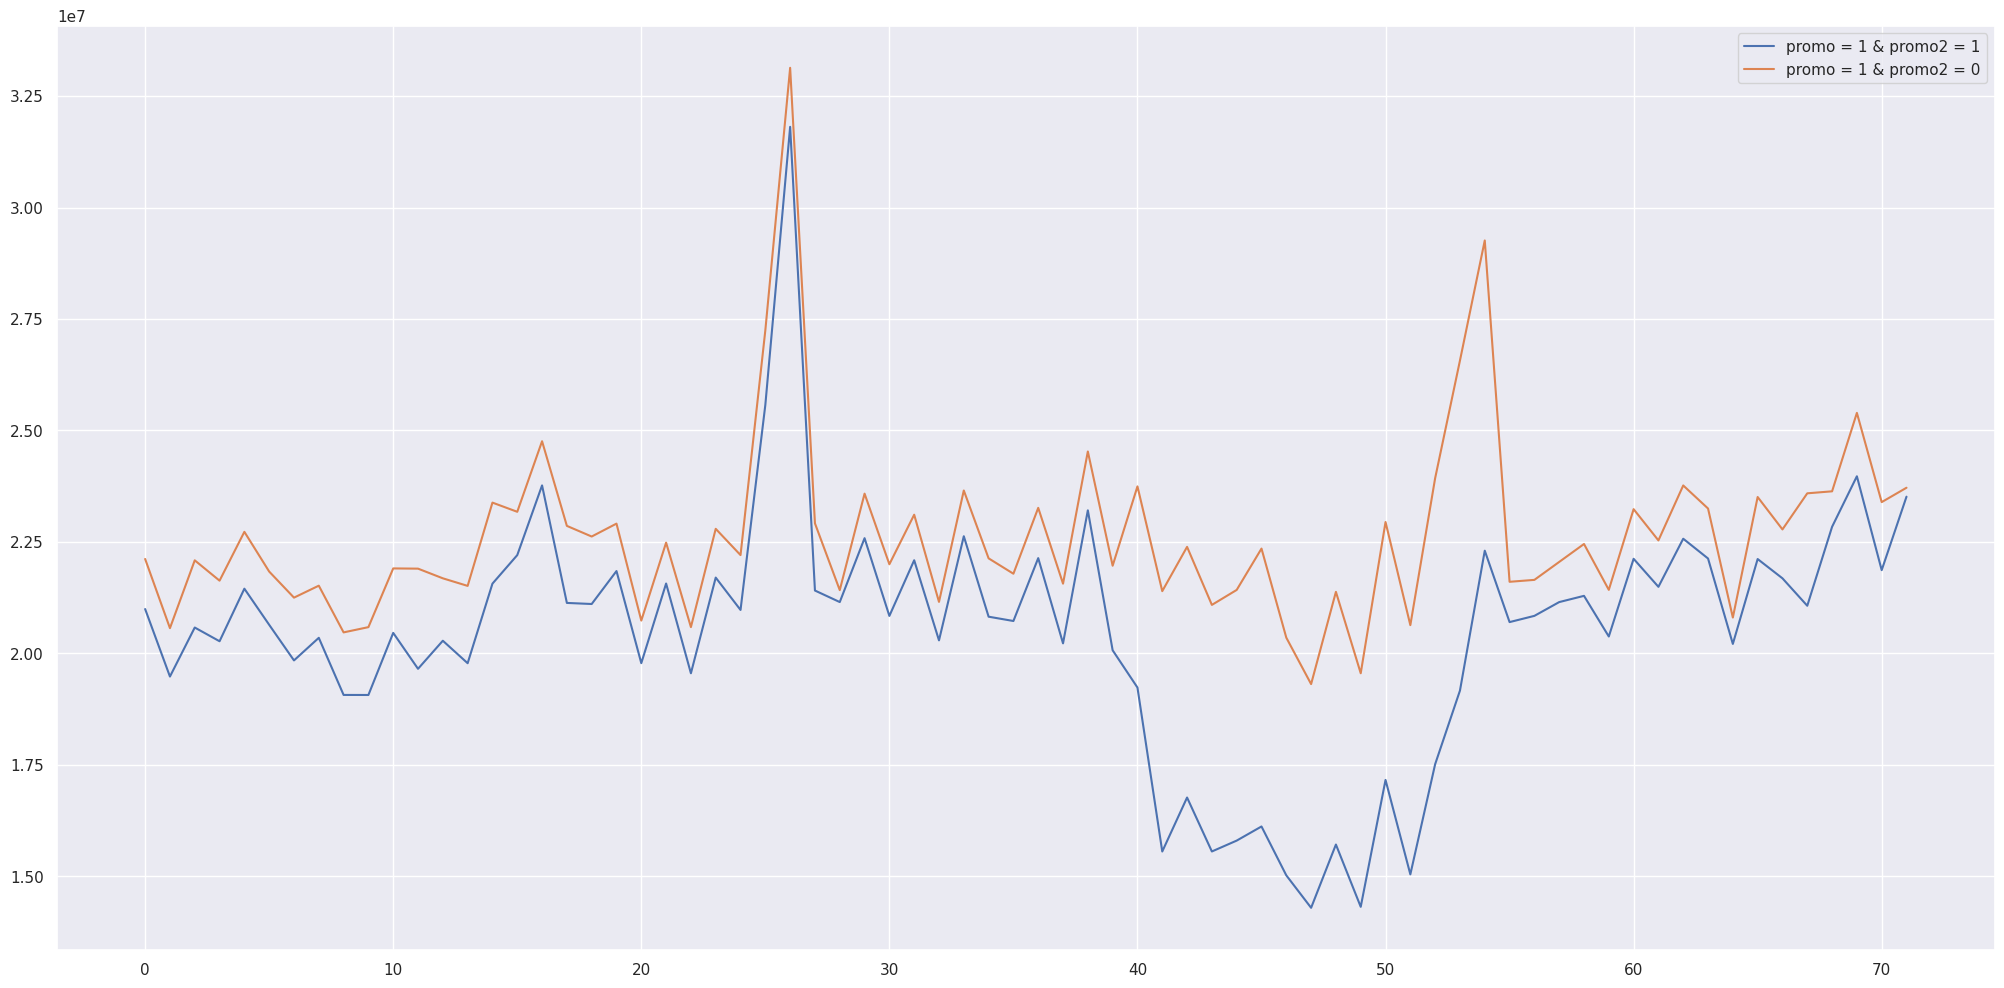

In [55]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['promo = 1 & promo2 = 1', 'promo = 1 & promo2 = 0']);

### H7. Stores open during the Christmas holiday should sell more.
### FALSE Stores open during the Christmas holiday sell less.

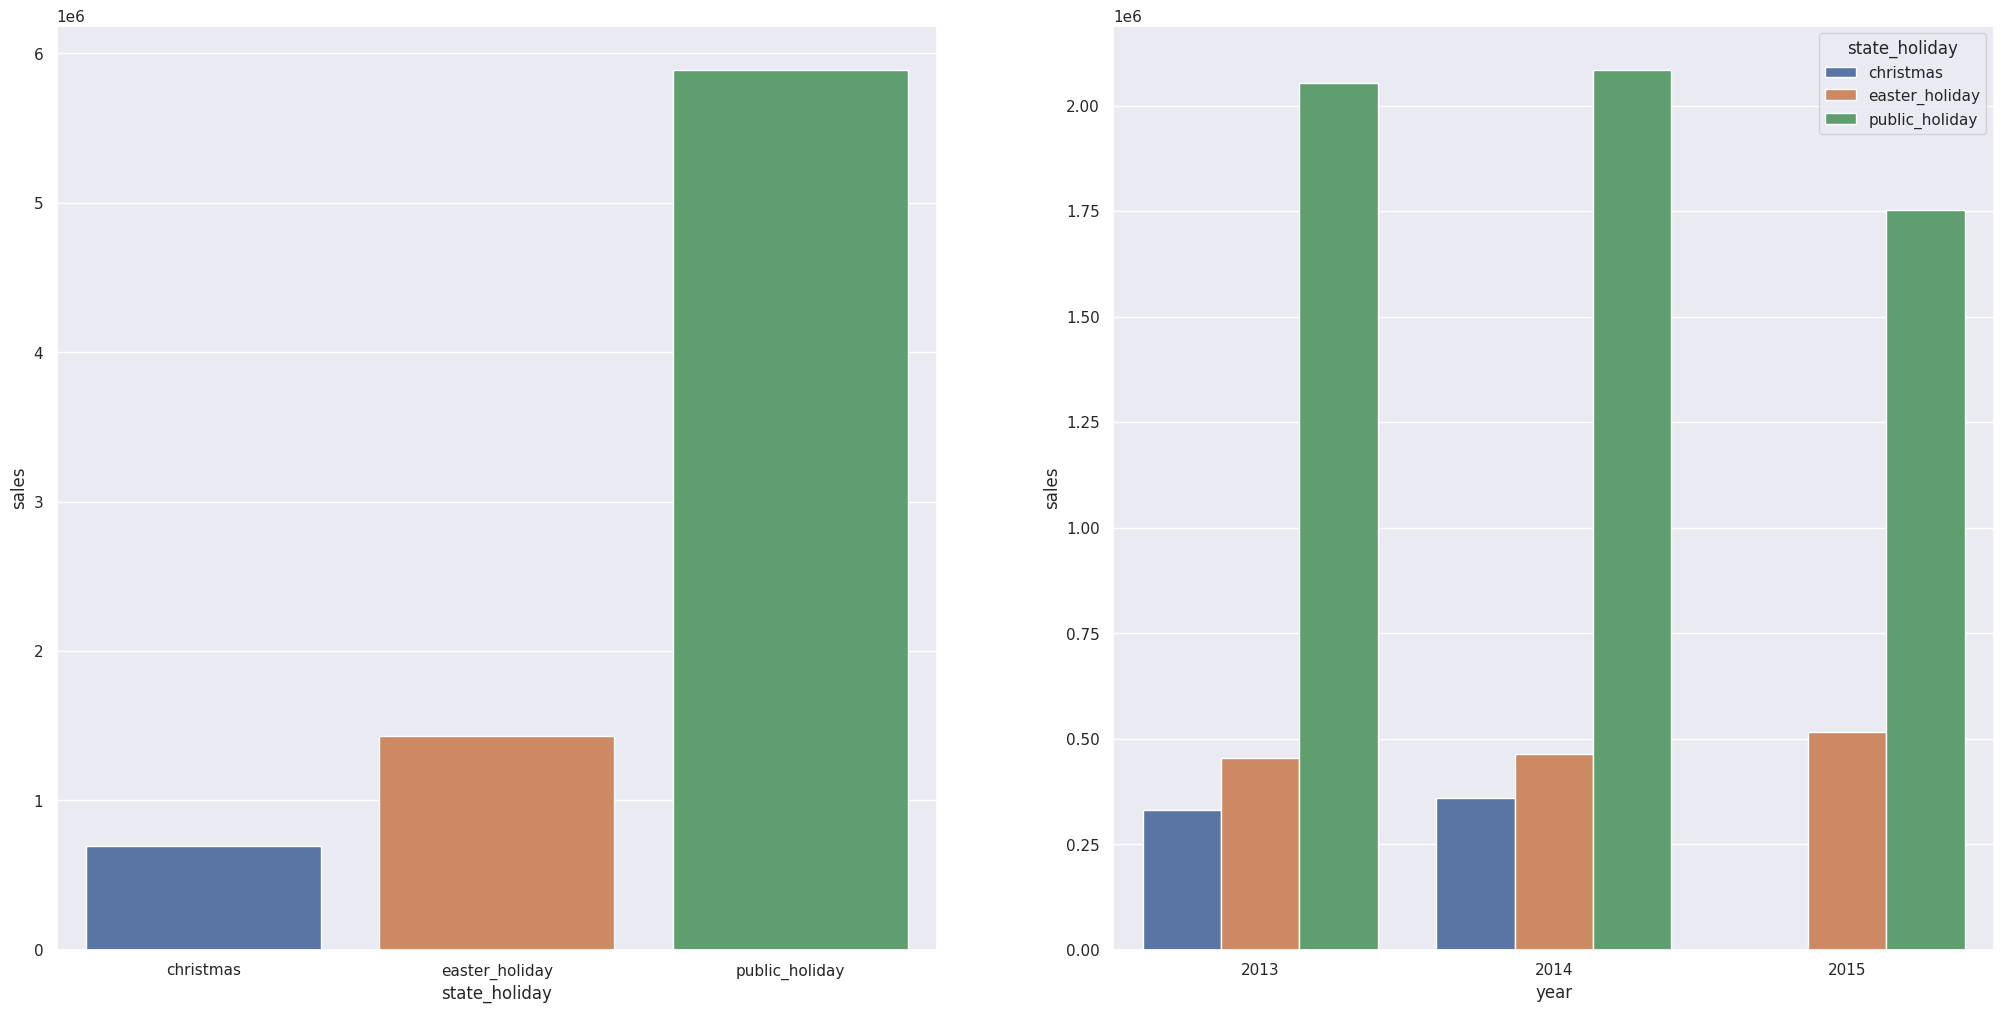

In [62]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8. Stores should sell more over the years.
### FALSE Stores sell less over the years.

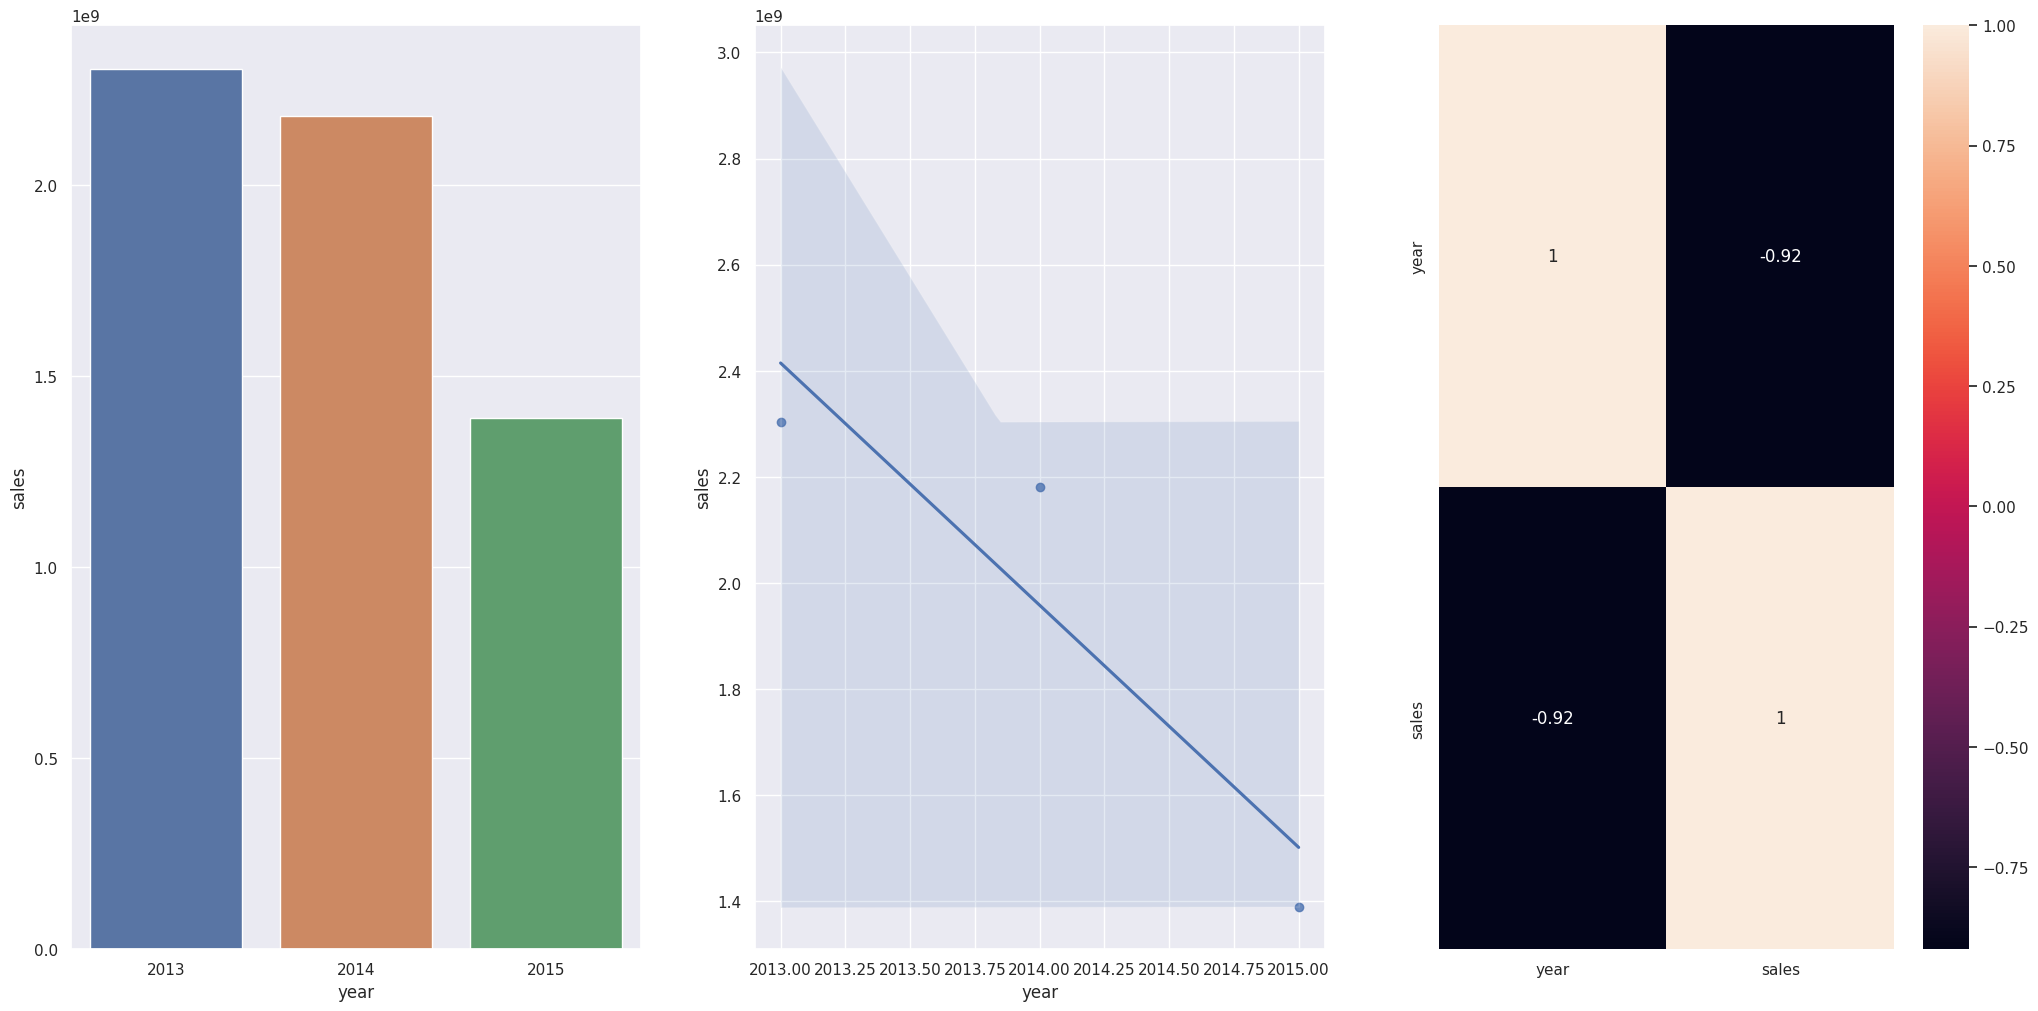

In [63]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H9. Stores were supposed to sell more in the second half of the year.
### FAKE Stores sell less in the second half of the year.

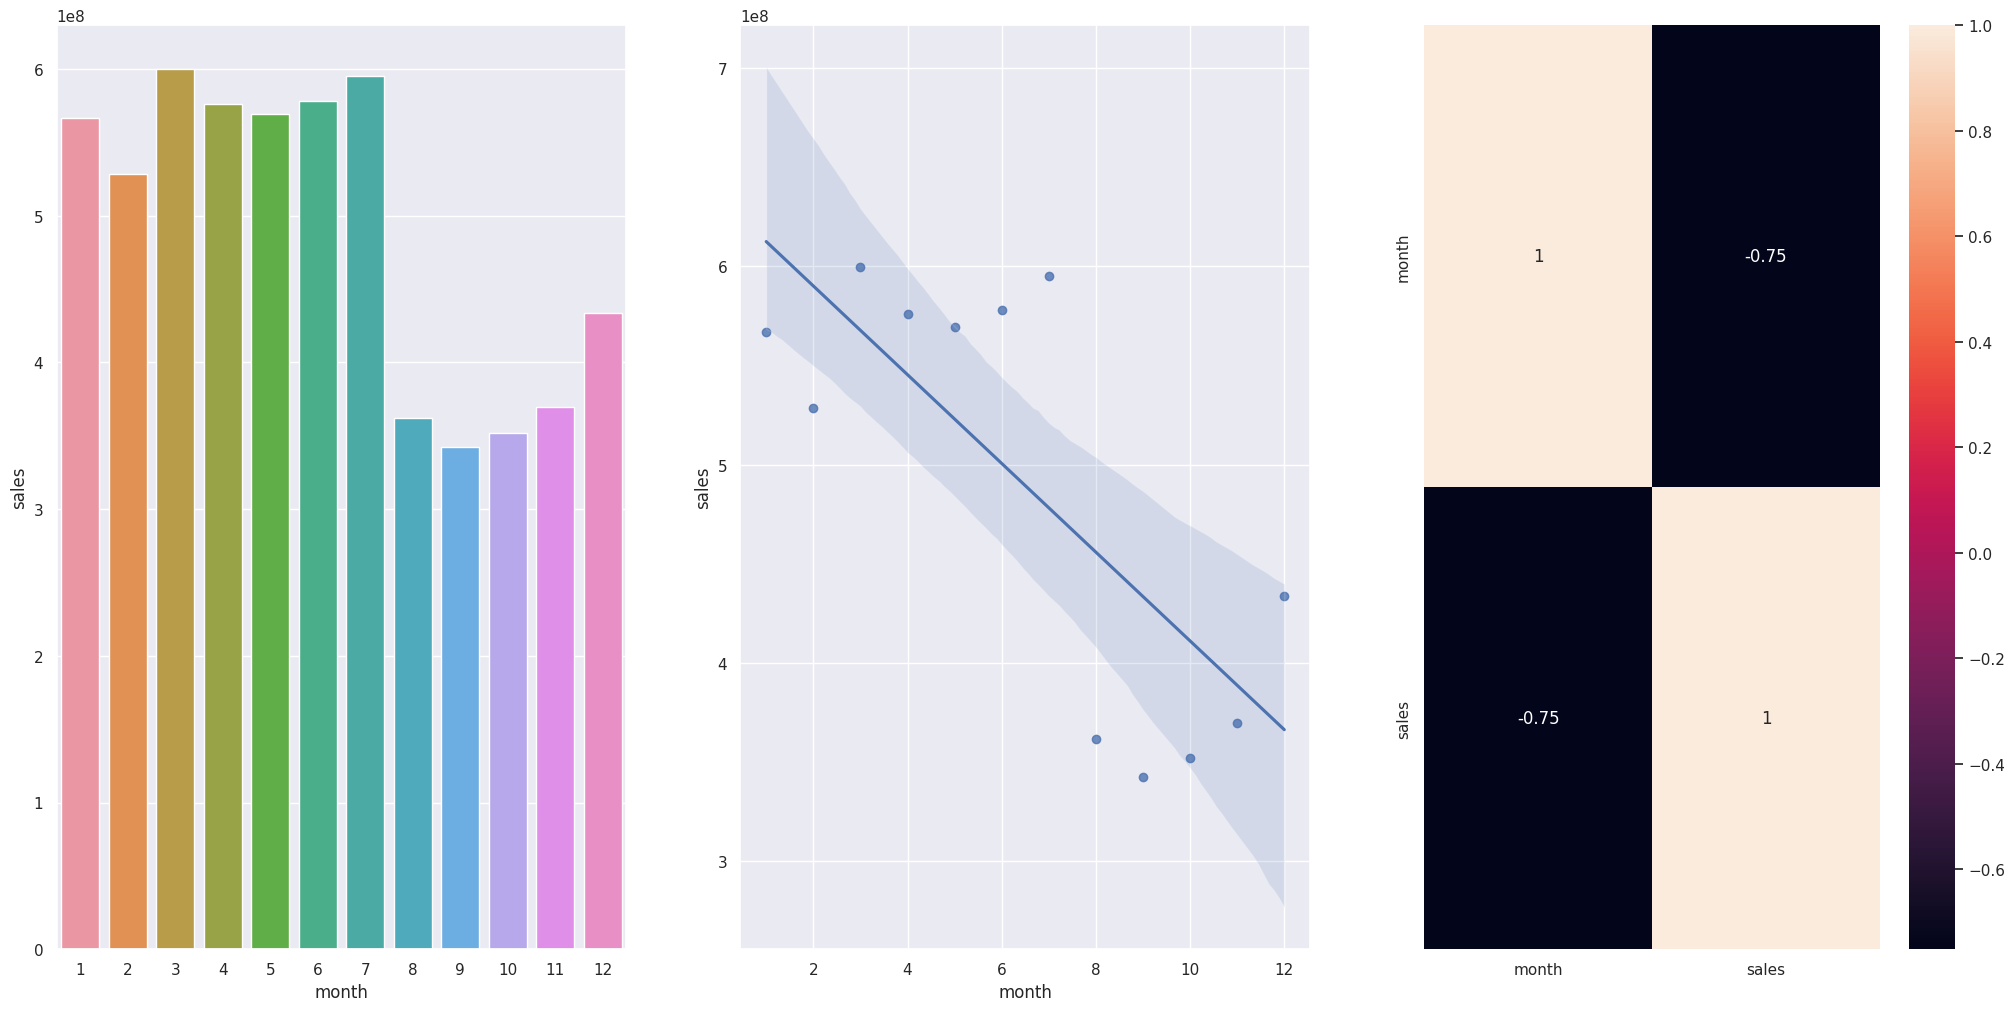

In [65]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2 )
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H10. Stores were supposed to sell more after the 10th of each month.
### TRUE Stores sell more after the 10th of each month.

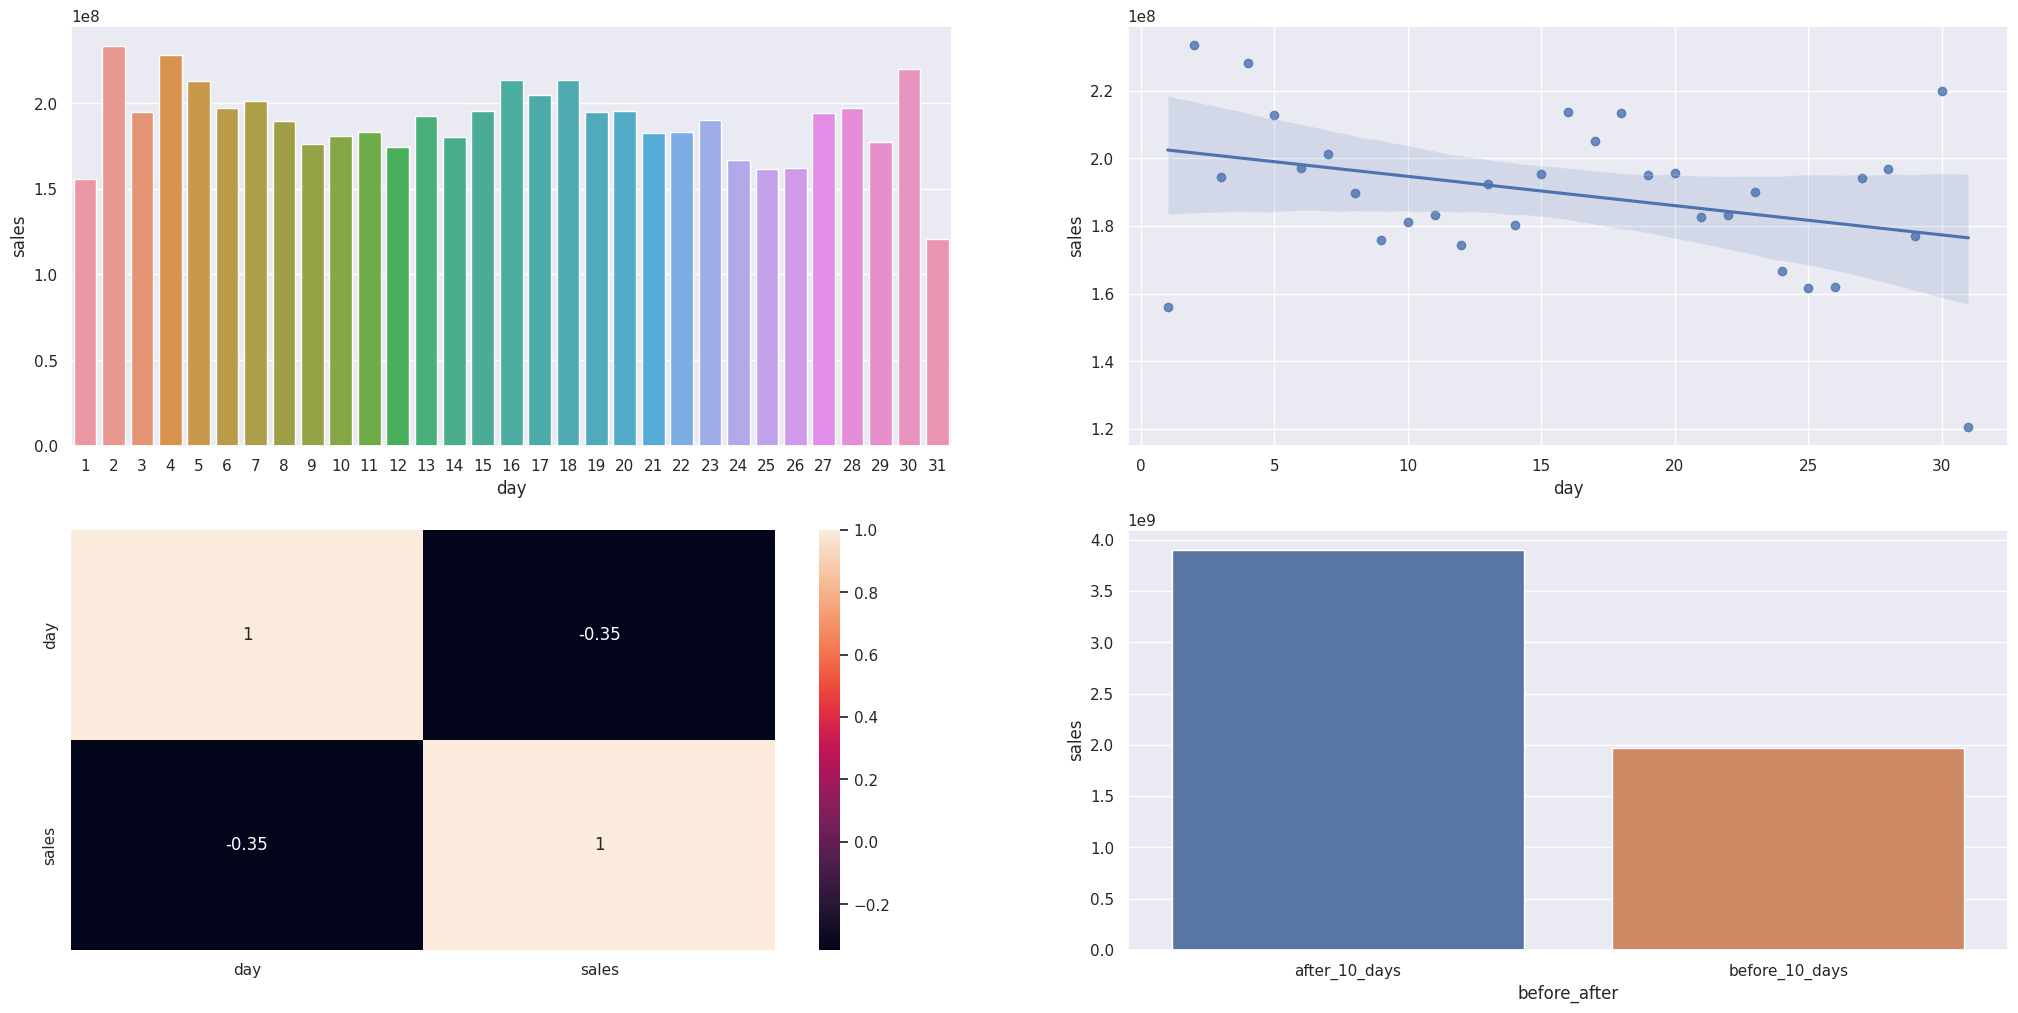

In [216]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method ='pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x ='before_after', y = 'sales', data = aux2);

### H11. Stores should sell less on weekends.
### TRUE Stores sell less on weekends

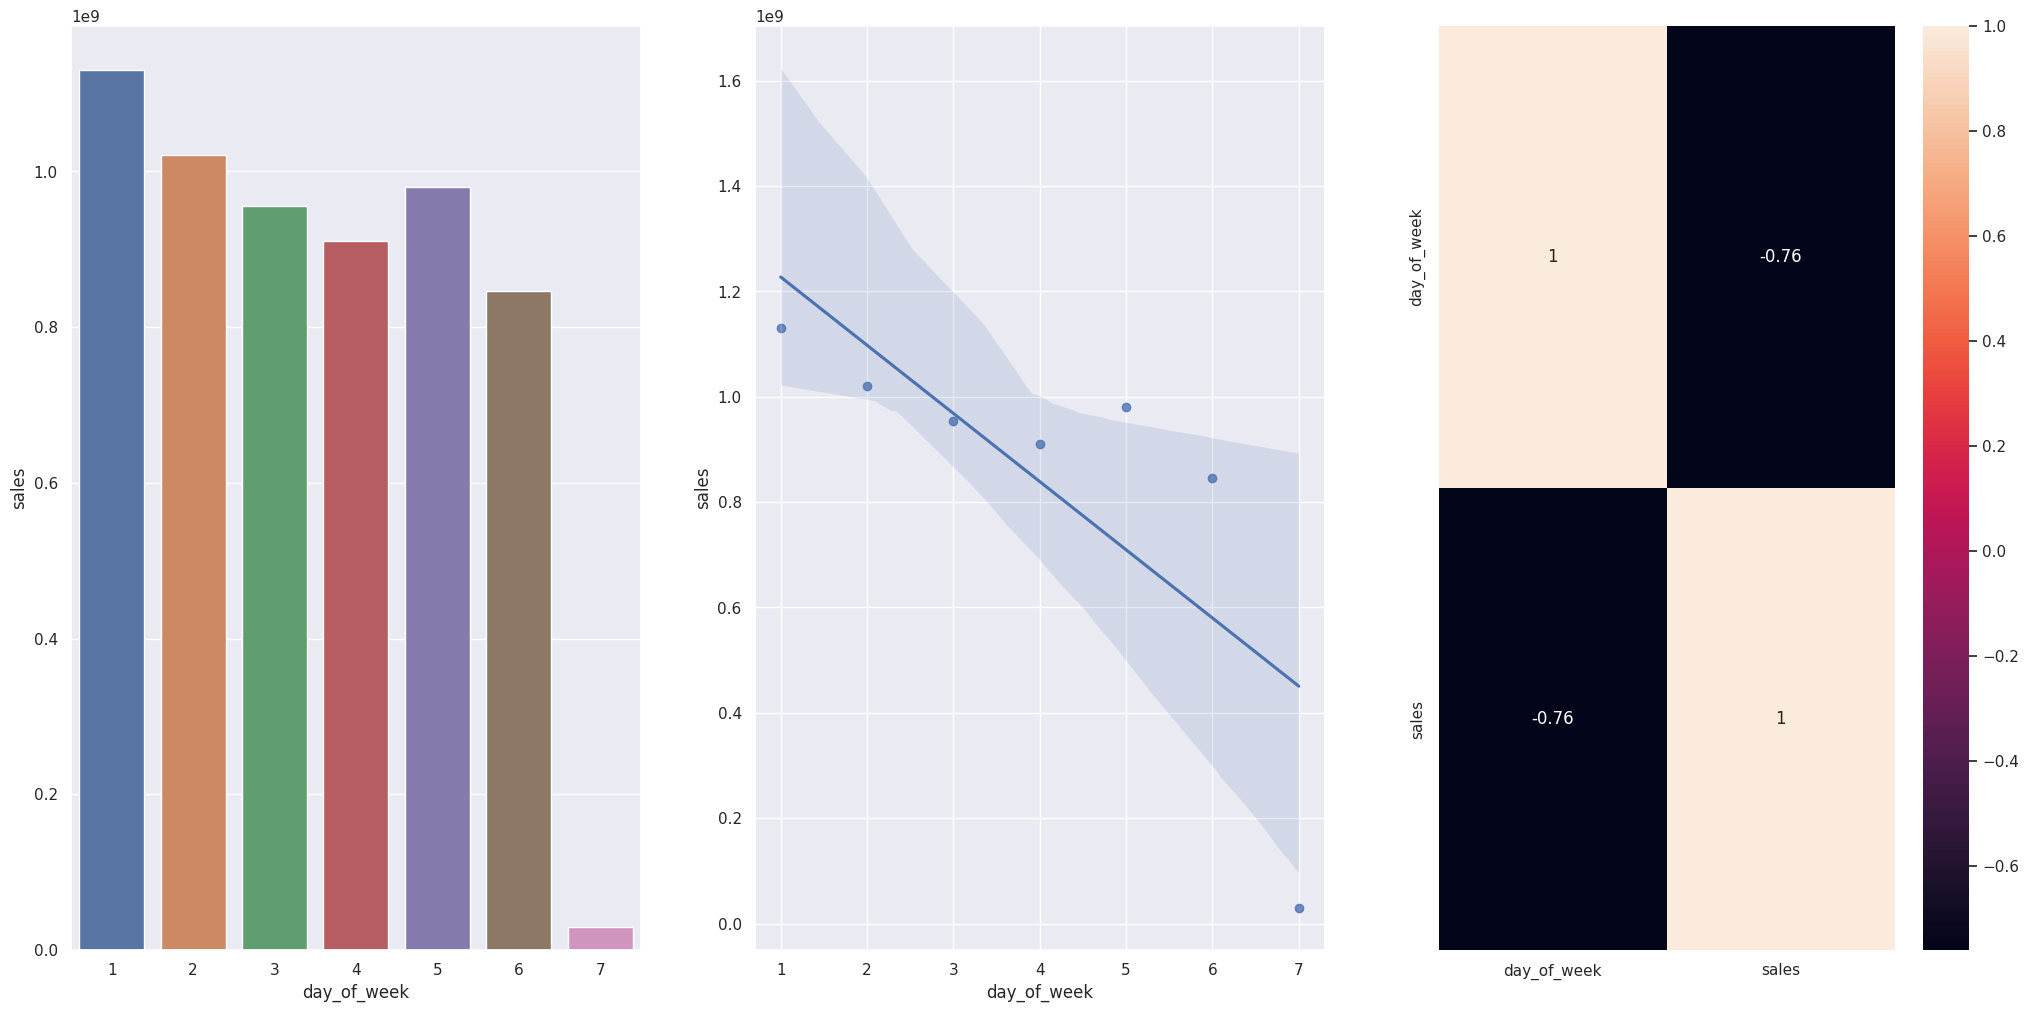

In [217]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12. Stores should sell less during school holidays.

### TRUE Stores sell less during school holidays, except for the months of July and August.

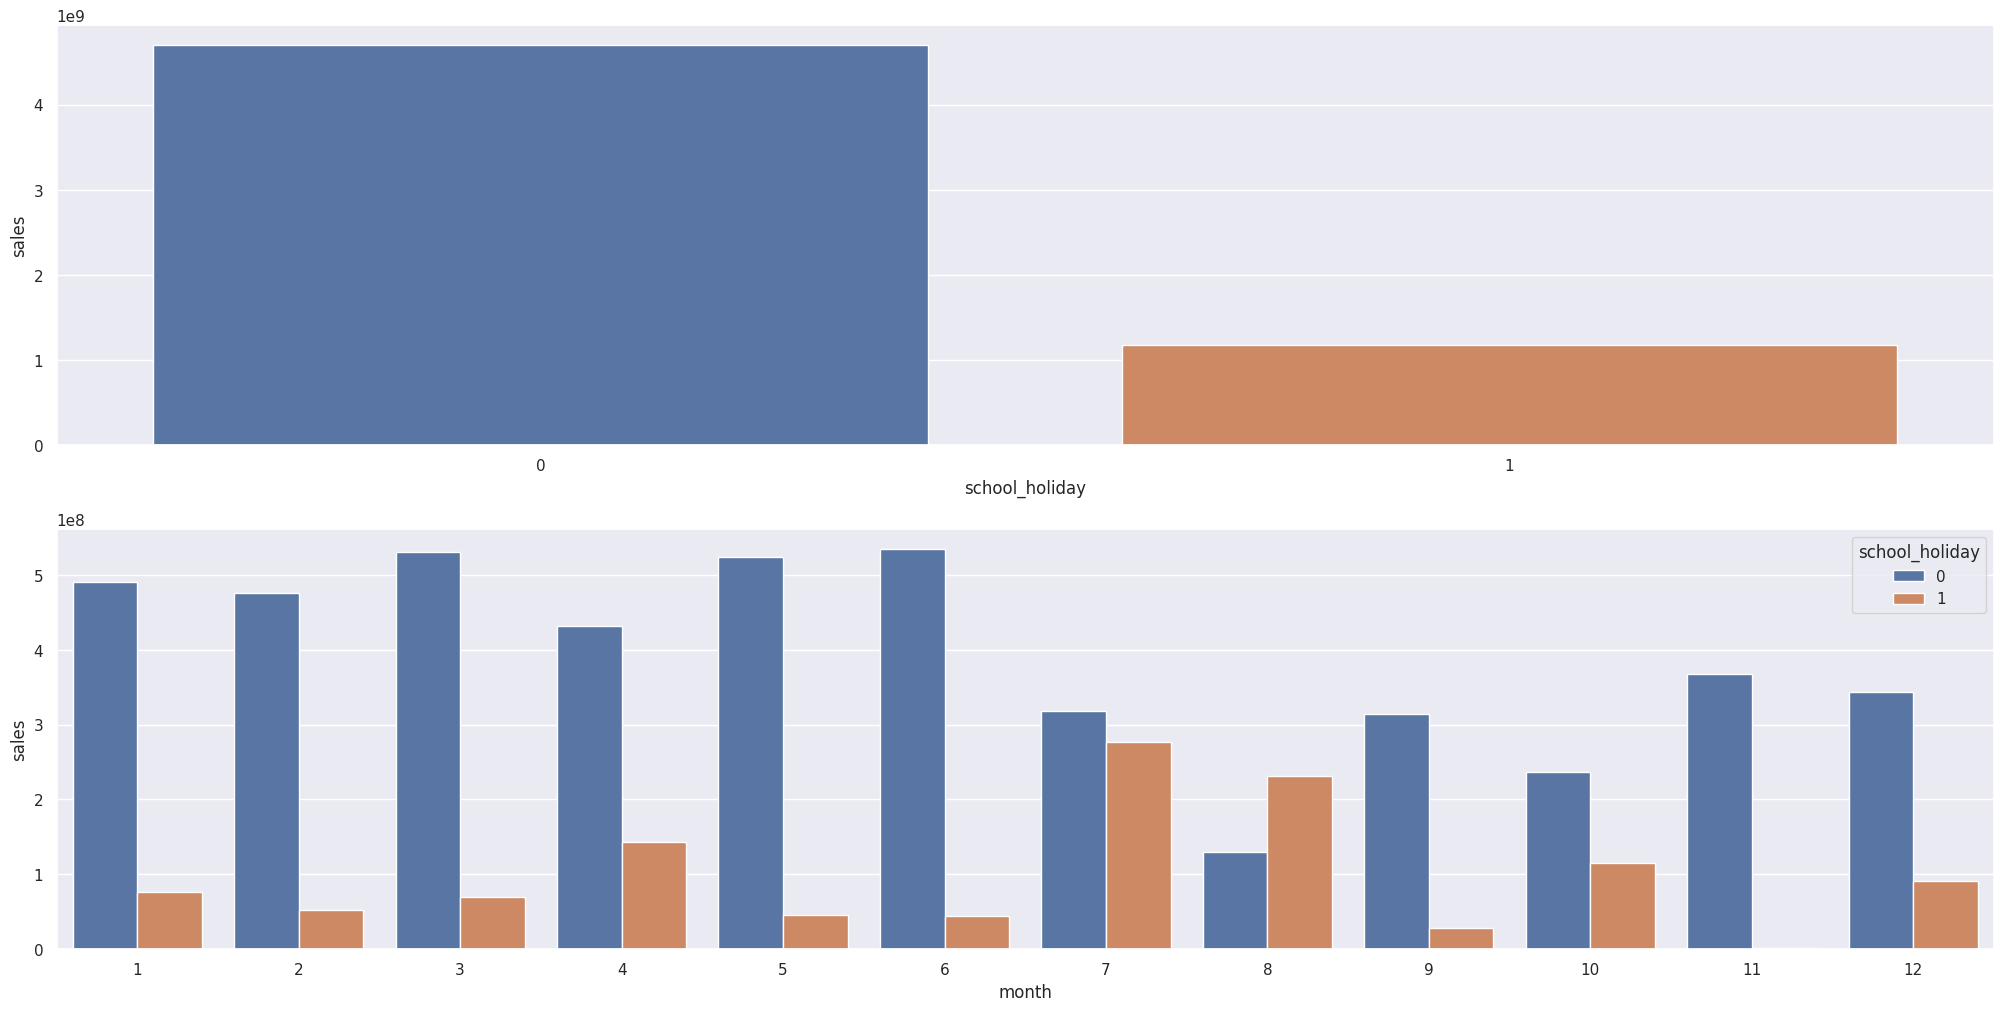

In [211]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### H13. Stores that practice promo2 in Mar,Jun,Sept,Dec sell more

### FALSE Stores that practice promo2 in Mar,Jun,Sept,Dec sell less

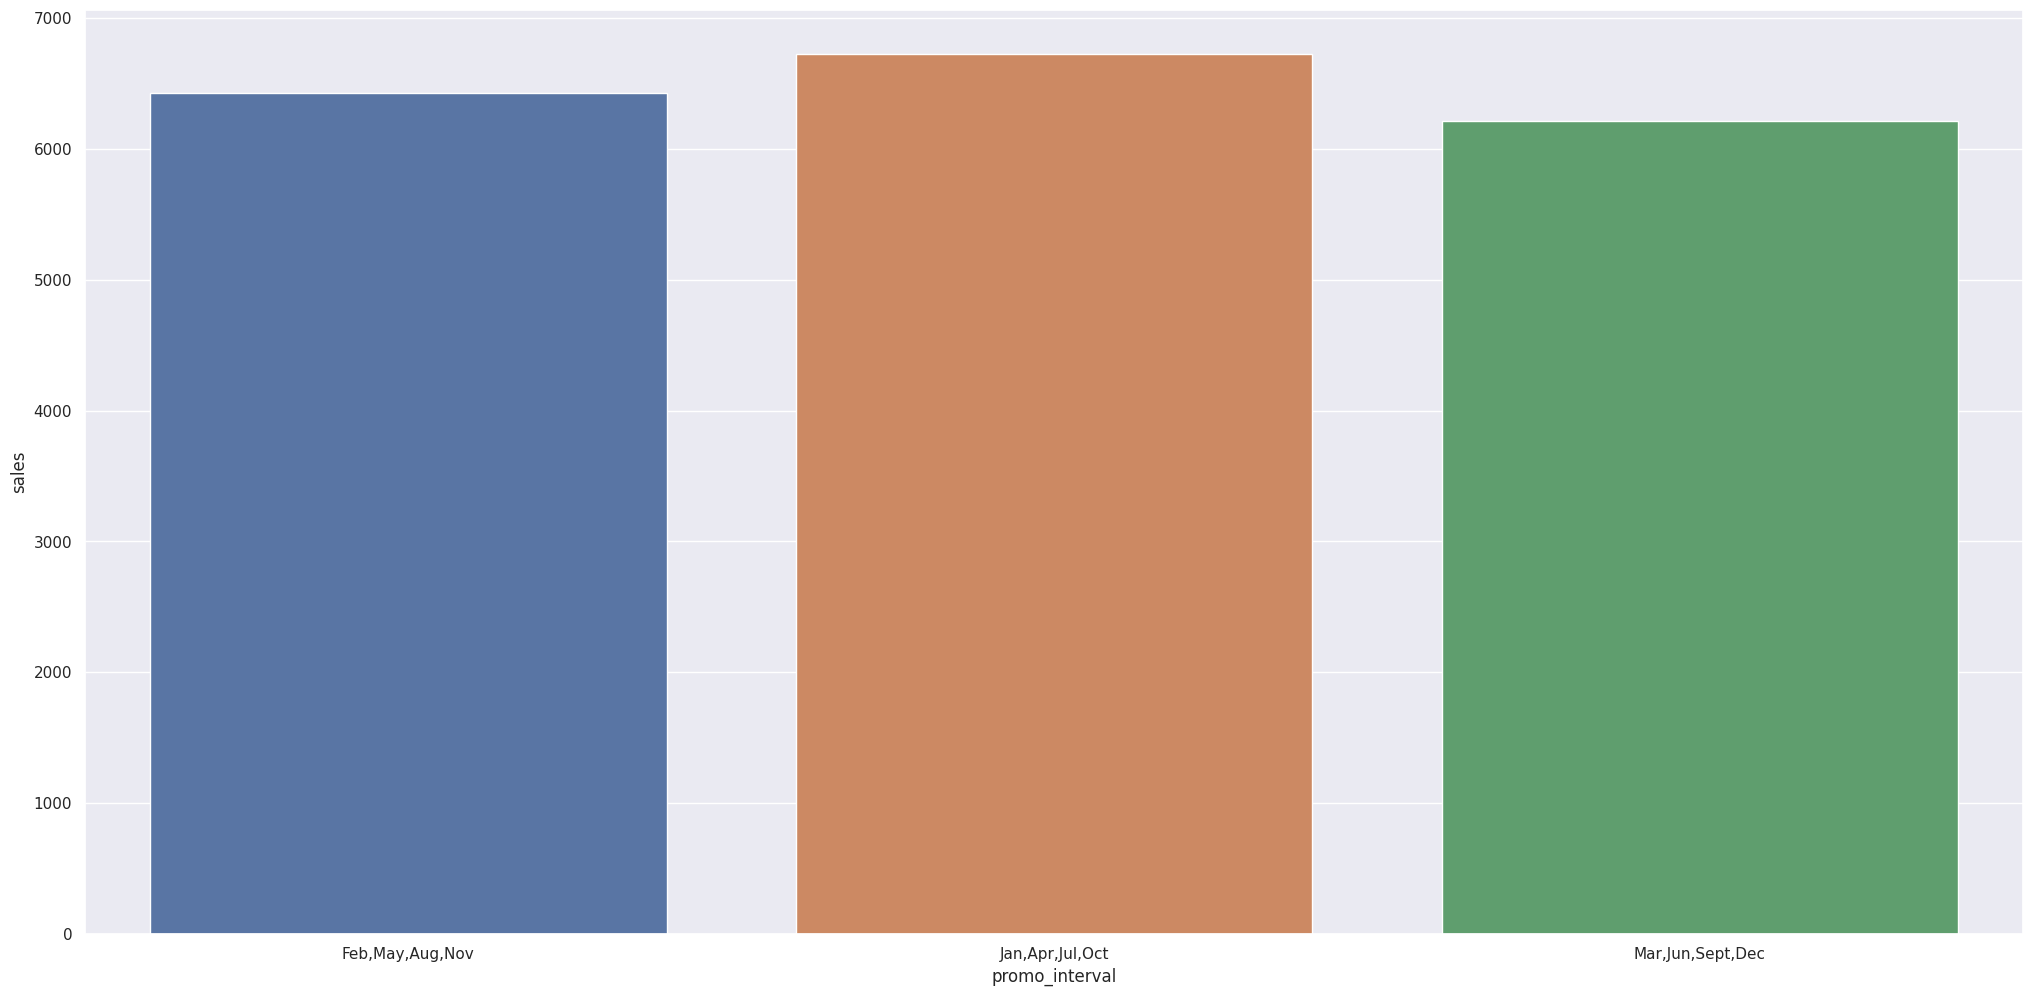

In [67]:
aux = df4[df4['promo_interval'] != 0]

aux1 = aux[['promo_interval', 'sales']].groupby('promo_interval').mean().reset_index()
sns.barplot(x = 'promo_interval', y = 'sales', data = aux1);

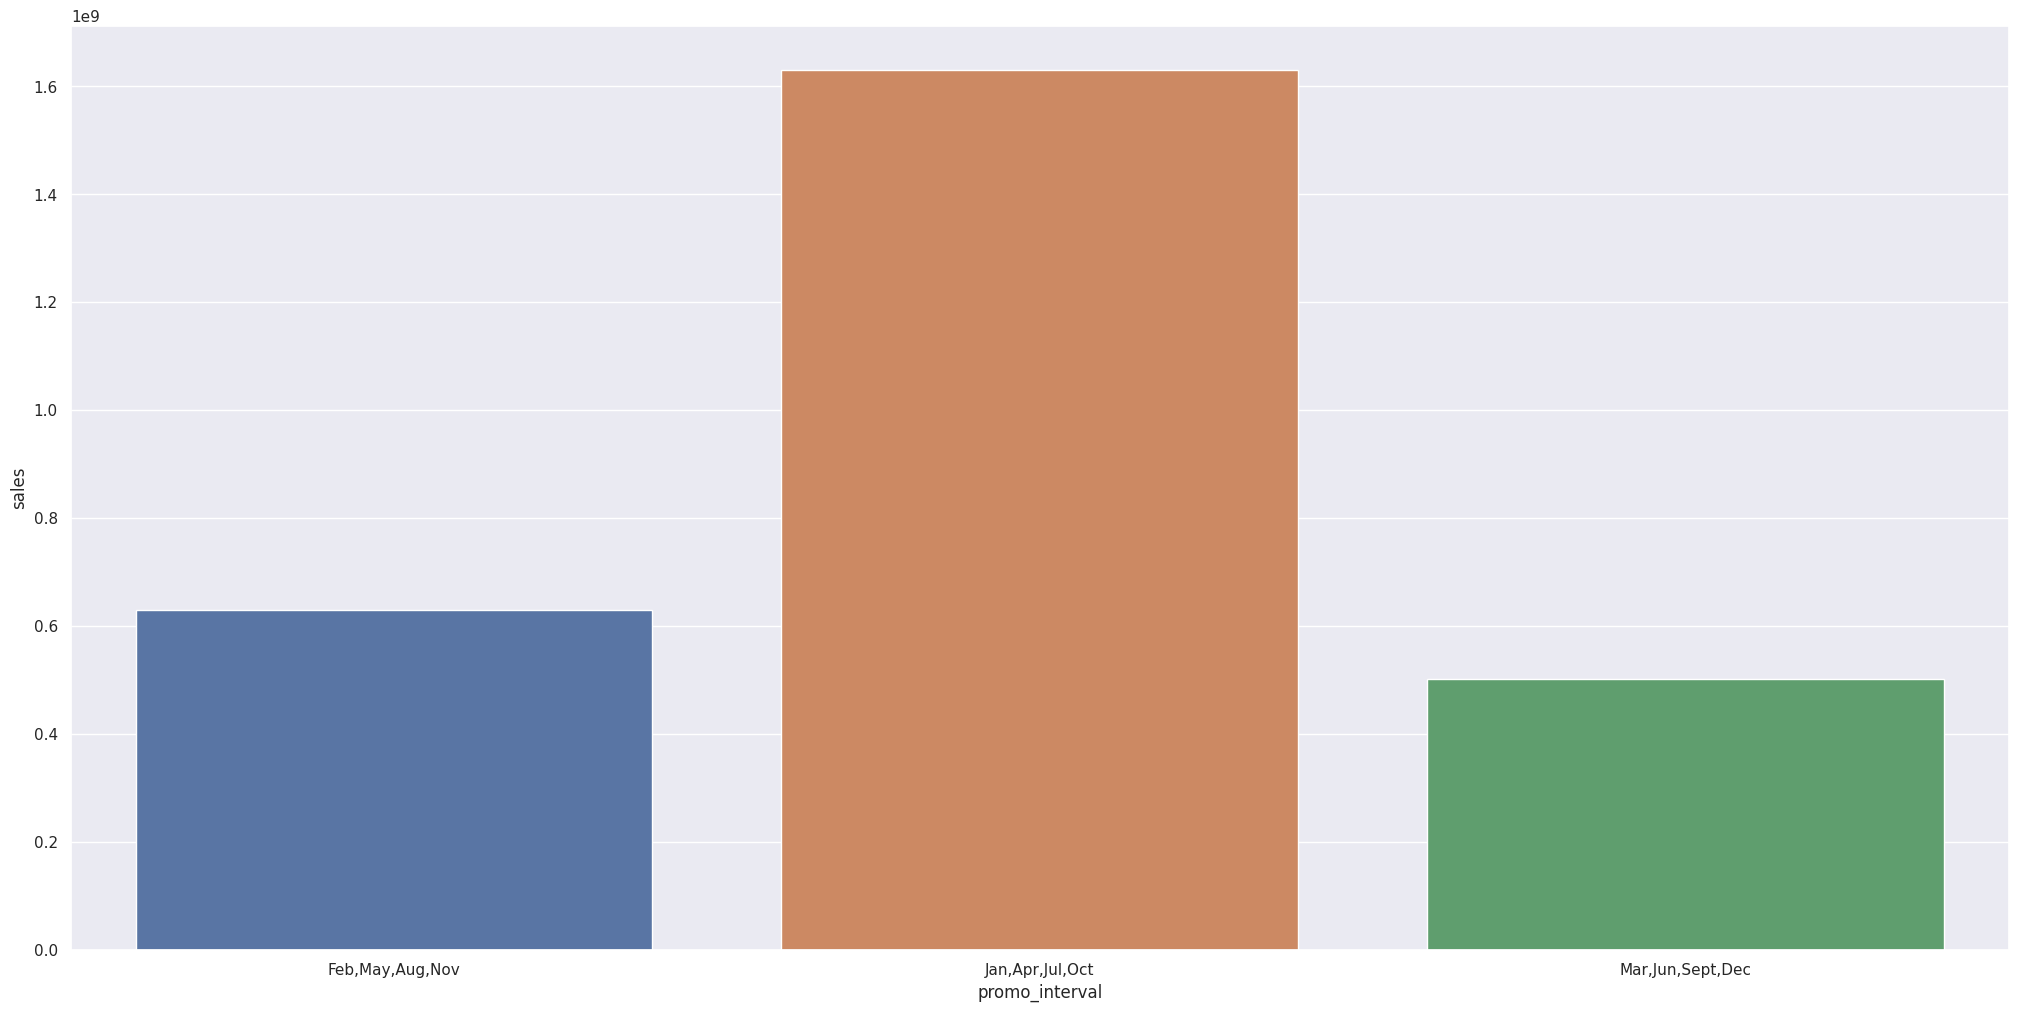

In [207]:
aux = df4[df4['promo_interval'] != 0]

aux1 = aux[['promo_interval', 'sales']].groupby('promo_interval').sum().reset_index()
sns.barplot(x = 'promo_interval', y = 'sales', data = aux1);

### 4.2.1. Summary of Hypotheses

In [68]:
from tabulate import tabulate

In [69]:
tab =[['Hypothesis', 'Conclusion',  'Relevancie'],
      ['H1',         'False',       'Low'],
      ['H2',         'False',       'Average'],
      ['H3',         'False',       'Average'],
      ['H4',         'False',       'Average'],
      ['H5',         'False',       'High'],
      ['H6',         'False',       'Average'],
      ['H7',         'False',       'Average'],
      ['H8',         'False',       'High'],
      ['H9',         'False',       'High'],
      ['H10',        'True',        'High'],
      ['H11',        'True',        'High'],
      ['H12',        'True',        'Low']
      ['H13',        'False',       'High']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevancie
------------  ------------  ------------
H1            False         Low
H2            False         Average
H3            False         Average
H4            False         Average
H5            False         Average
H6            False         Low
H7            False         Average
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

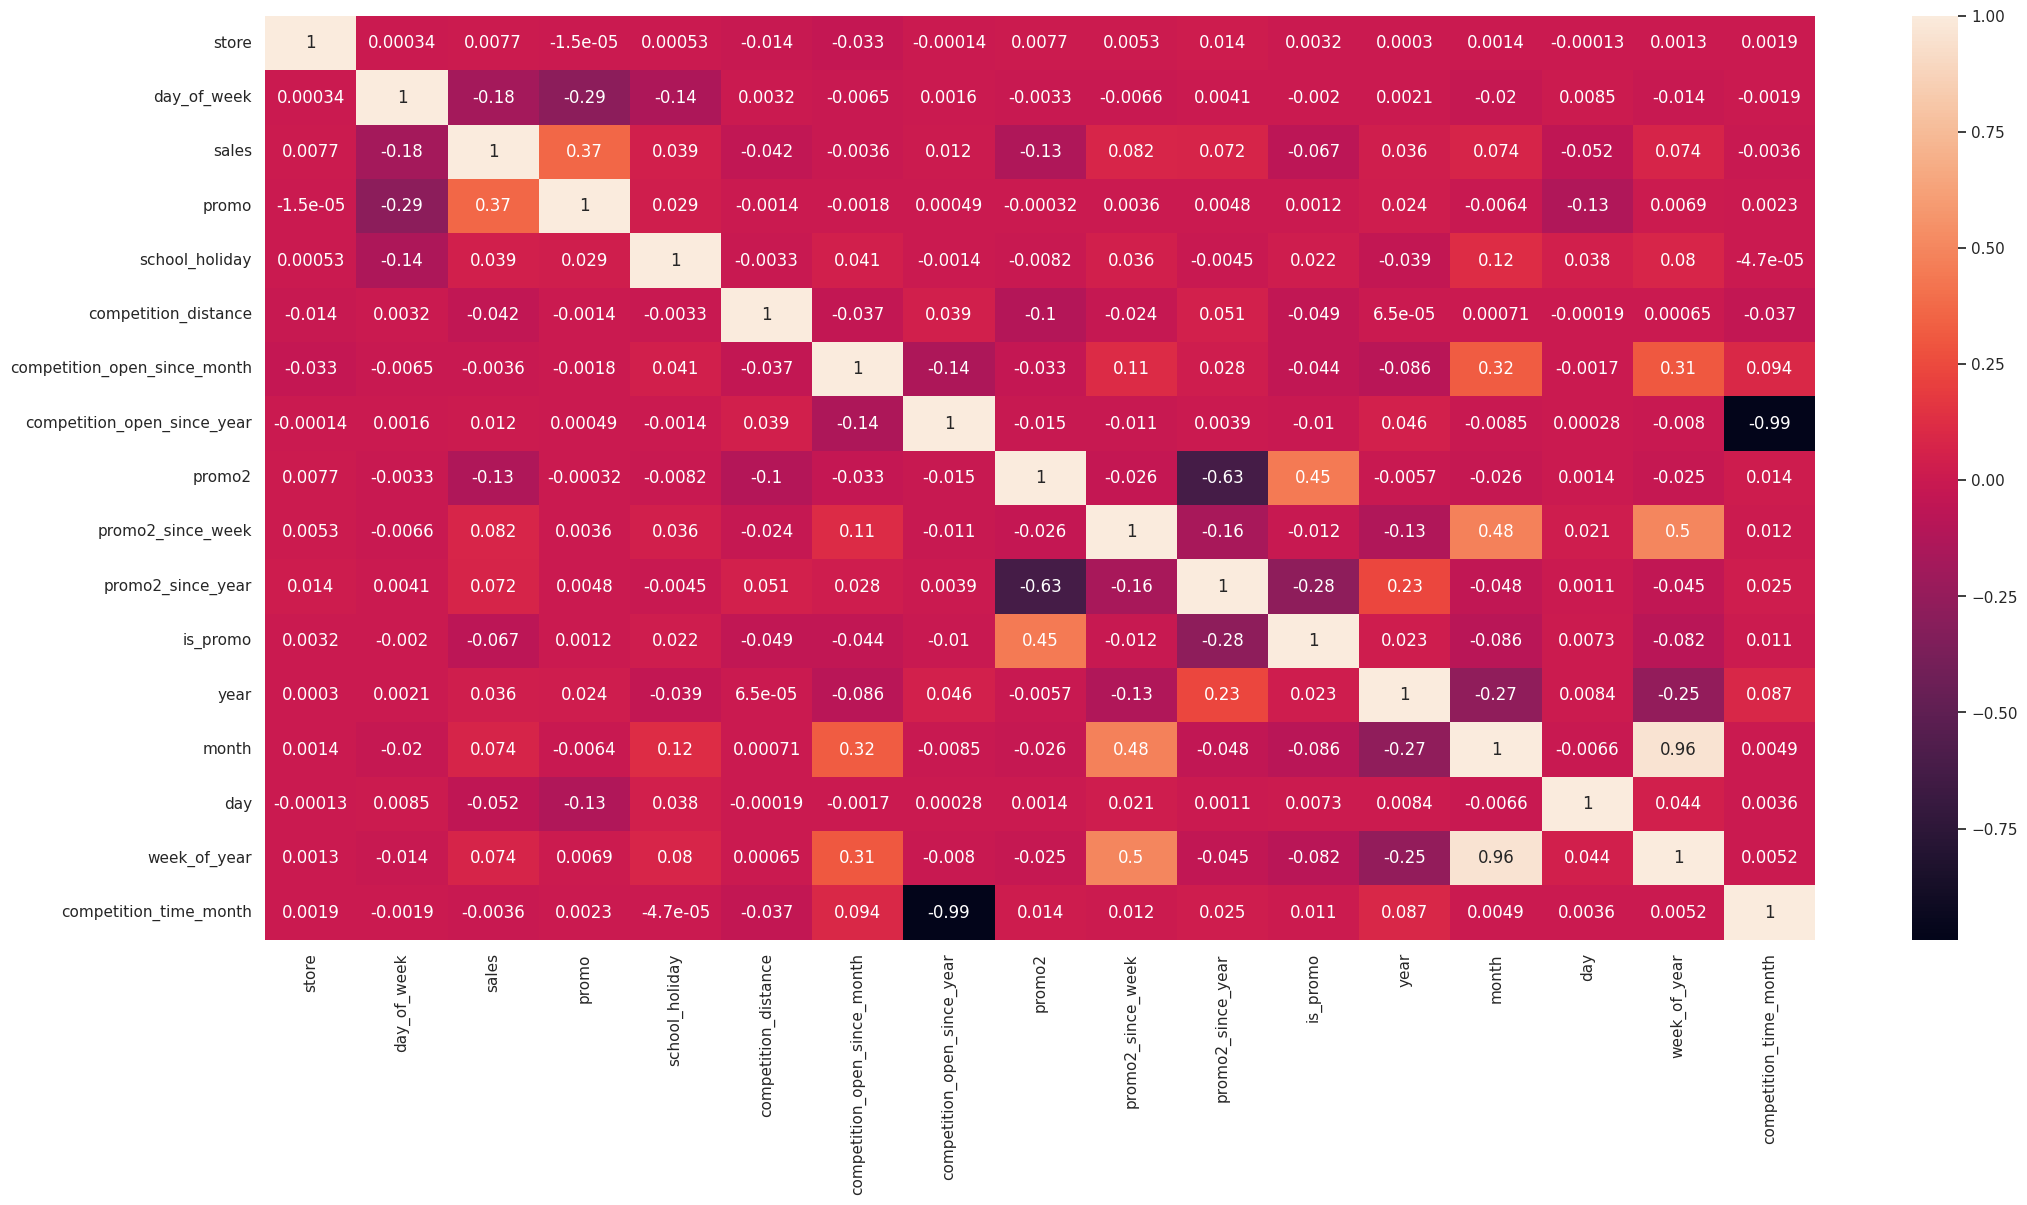

In [70]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

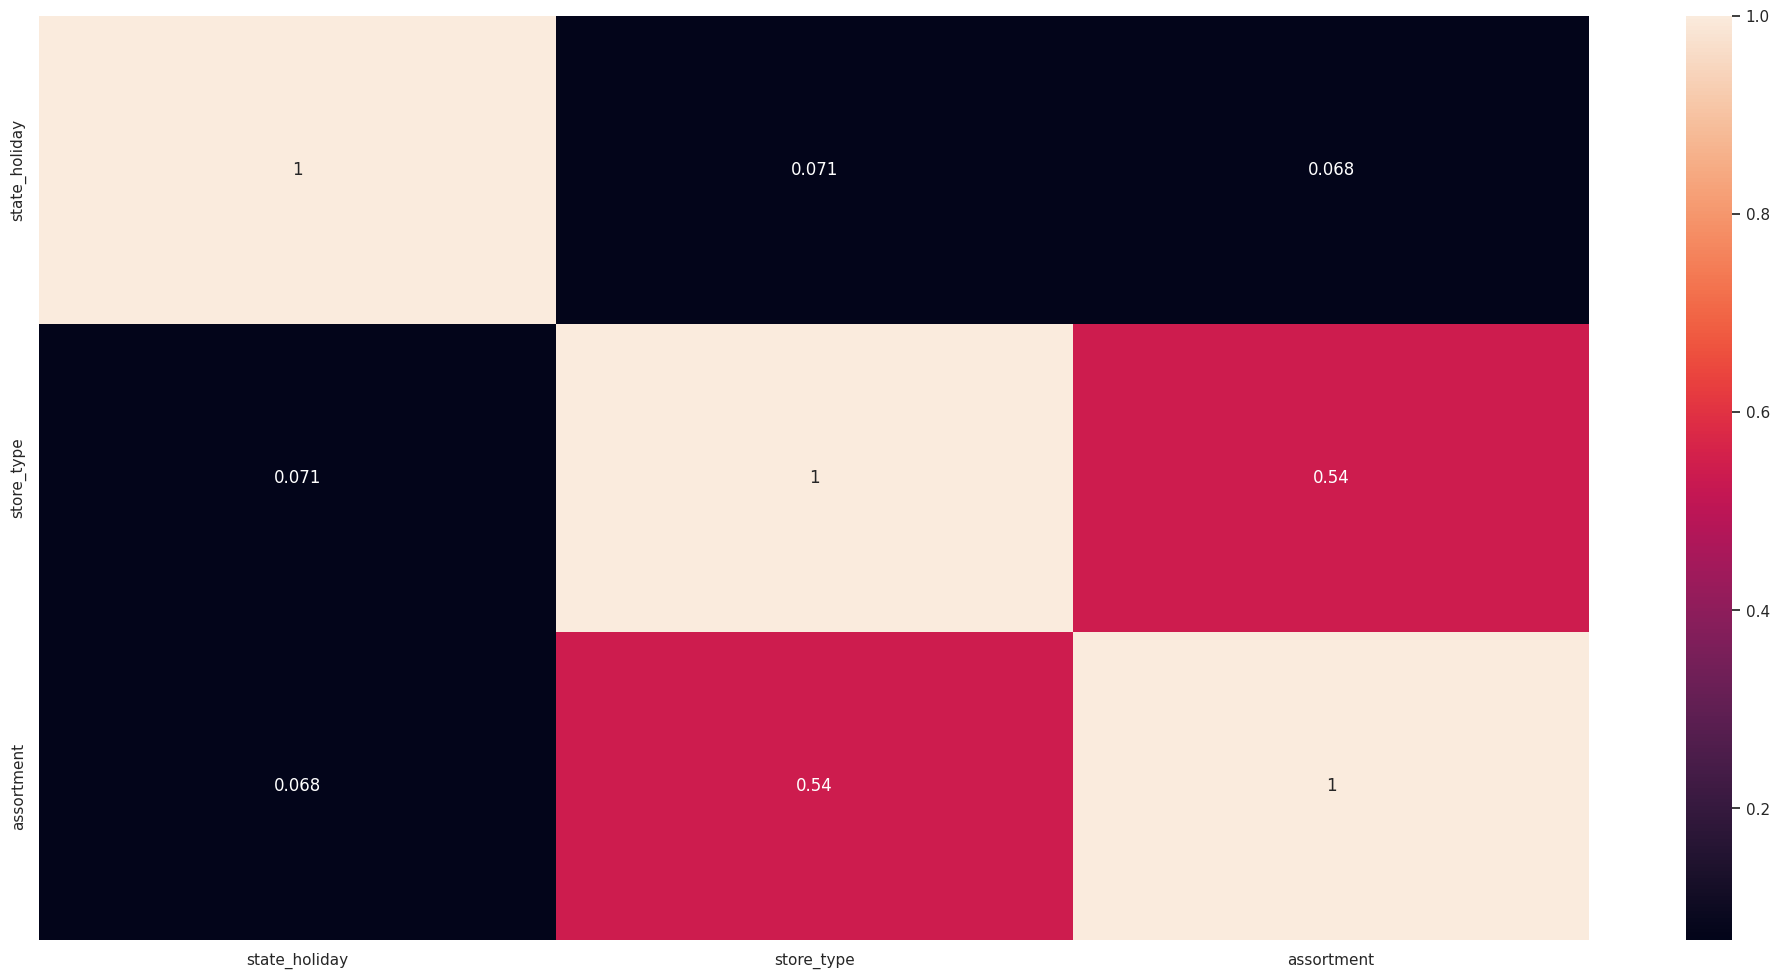

In [73]:
# only categorical data
a = df4.select_dtypes(include = 'object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'],    a['state_holiday'])
a5 = cramer_v(a['store_type'],    a['store_type'])
a6 = cramer_v(a['store_type'],    a['assortment'])

a7 = cramer_v(a['assortment'],    a['state_holiday'])
a8 = cramer_v(a['assortment'],    a['store_type'])
a9 = cramer_v(a['assortment'],    a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type':    [a4, a5, a6],
                  'assortment':    [a7, a8, a9]})

d = d.set_index(d.columns)
sns.heatmap(d, annot = True);

# 5.0. PASSO 05 - DATA PREPARATION

In [74]:
df5 = df4.copy()

### 5.1. Normalizacao

In [81]:
# There are no variables with normal distribution to be applied the normalization

### 5.2. Rescaling

In [83]:
rs  = RobustScaler()
mms = MinMaxScaler()

# competition distance
# sns.boxplot(df5['competition_distance']) # to see if there is outliers
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

### 5.3. Transformacao

#### 5.3.1. Encoding

In [85]:
# categoric -> numeric feature

In [86]:
# state_holiday - One Hot Encoding (creates new columns)
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding (just change the names by numbers)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding (related to hierarchical sequence numbers)
assortment_dict   = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2. Response Variable Transformation

In [87]:
df5['sales'] = np.log1p(df5['sales']) # change the shape to a normal distribution (benefit the algorithm)
#sns.distplot(df5['sales'])

#### 5.3.3. Nature Transformation

In [88]:
# apply ciclycal atribute to the time columns

In [89]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - FEATURE SELECTION (crisp - modelagem dos dados)

In [90]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [91]:
# delete columns that were used to generate others, or are not necessary anymore
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [92]:
df6[['store', 'date']].groupby('store').min().reset_index() # start date
df6[['store', 'date']].groupby('store').max().reset_index() # final date

# excluding the last 6 weeks from de dataset to generate the training dataset
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [93]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'. format(X_train['date'].min()))
print('Training Max Date: {}'. format(X_train['date'].max()))

print('\nTest Date Min Date: {}'. format(X_test['date'].min()))
print('Test Max Date: {}'. format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Date Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector (4 to 5 hours)

In [94]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values # delete training features, values to get only values 
                                                             # and not send a datframe to the algoritm
y_train_n = y_train.values.ravel() # ravel is to vetorize the values got

In [95]:
# define randomforestregressor
rf = RandomForestRegressor(n_jobs = -1) # so the commando will use all machine cores and meake the tree in paralel

In [96]:
# Define boruta
# rf - random forest, estimators automatic, verbose to the command print the logs, random state to select the 
# variables with the same aleatority
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [97]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date', 'sales'], axis = 1)  # to feed the next command with an entire dataframe, and
                                                        # not just values (fs - feature select)

In [98]:
# iloc because we are now working with index and not names
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

In [99]:
# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta)) # compare columns and
                                                                                  # give the ones that is not on
                                                                                  # the selected list

## 6.3 Manual Feature Selection

In [110]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin', # added
    'month_cos',  
    'day_sin',
    'day_cos',
    'week_of_year_sin', #added
    'week_of_year_cos']

# columns to add
# adding date to separate the dataset later and sales to train the algorithm
#feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend(feat_to_add)


In [111]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 PASSO 07 - MACHINE LEARNING MODELING (crisp - ml algorithm)

In [112]:
# initially without date and sales
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

# adding date and sales again to separate training and validation for time series

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# Time series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [113]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales' : 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['prediction'] # hat to indicate prediction

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # y_test -> real values
                                                                                       # exp makes the antilog
                                                                                       # from section 5
        
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [115]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [116]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Linear Regression Regularized Model

In [117]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train) # alpha serve para limitar os pesos

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [118]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor

In [119]:
# model
# n_estimators -> size tree  |  n_jobs -> to run in parallel  |  random_state -> aleatority source
rf = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train, y_train)

In [120]:
# prediction
yhat_rf = rf.predict(x_test)

In [121]:
# performance
rf_result = ml_error('Random forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,691.196156,0.101541,1030.914907


### 7.4.1 Random Forest Regressor - Cross Validation

In [122]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv 


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,852.87+/-224.09,0.12+/-0.02,1277.81+/-326.64


## 7.5 XGBoost Regressor

In [123]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = 25,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

In [124]:
# prediction
yhat_xgb = model_xgb.predict(x_test)

In [125]:
# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6985.837811,0.998442,7620.095855


### 7.5.1 XGBoost Regressor - Cross Validation

In [126]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
xgb_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7355.16+/-598.86,1.0+/-0.0,8008.18+/-698.42


## 7.6 Compare model's Performance

### 7.6.1 Single Performance

In [127]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,691.196156,0.101541,1030.914907
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6985.837811,0.998442,7620.095855


### 7.6.2 Real Performance - Cross Validation

In [128]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv
# even the performance of XGBoost Regressor is not the best for academic purpose this model will be used

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,852.87+/-224.09,0.12+/-0.02,1277.81+/-326.64
0,XGBoost Regressor,7355.16+/-598.86,1.0+/-0.0,8008.18+/-698.42


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING (crisp - ml algorithm)

## 8.1 Random Search

In [129]:
param = {'n_estimators':     [1500, 1700, 2500, 3000, 3500],
         'eta':              [0.01, 0.03],
         'max_depth':        [3, 5, 9],
         'subsample':        [0.01, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [131]:
final_result = pd.DataFrame() # empty dataframe

for i in range(MAX_EVAL):
   # choose values for parameters randomly
   #hp = {k: random.sample(v, 1)[0] for k, v in param.items()} # k -> keas, v -> values
   hp = {k: np.random.choice(v, 1)[0] for k, v in param.items()}
   print(hp)
    
   # model
   model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'], # training is made by cross validation function
                                min_child_weight = hp['min_child_weight'])
   
       
   # performance
   result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
   final_result = pd.concat([final_result, result])

final_result # ~ 2 days

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.01, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.01, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.01, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1095.96+/-152.75,0.15+/-0.01,1590.22+/-215.24
0,XGBoost Regressor,1065.83+/-133.17,0.15+/-0.01,1537.52+/-193.32
0,XGBoost Regressor,837.49+/-139.52,0.12+/-0.01,1207.71+/-198.89
0,XGBoost Regressor,1073.23+/-136.03,0.15+/-0.01,1538.63+/-191.36
0,XGBoost Regressor,1299.06+/-138.54,0.18+/-0.01,1878.36+/-171.88


## 8.2 Final Model

In [133]:
# from early result
param_tuned = {'n_estimators':     3000,
               'eta':              0.01,
               'max_depth':        9,
               'subsample':        0.7,
               'colsample_bytree': 0.9,
               'min_child_weight': 15}

In [134]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = param_tuned['n_estimators'],
                             eta = param_tuned['eta'],
                             max_depth = param_tuned['max_depth'],
                             subsample = param_tuned['subsample'],
                             colsample_bytree = param_tuned['colsample_bytree'], # training is made by cross validation function
                             min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

In [135]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [136]:
# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned # ~ 2 hours

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,673.473471,0.098037,989.432974


In [137]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))


In [138]:
xgb_result_tuned['MPE'] = mpe
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,673.473471,0.098037,989.432974,-0.000347


# 9.0 PASSO 9 - TRADUCAO E INTERPRETACAO DO ERRO (crisp - algorithm analisys)

In [139]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales']      = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [140]:
# sum of prediction
df91     = df9[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: 
                    mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: 
        mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92     = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario']  = df92['prediction'] + df92['MAE']

# order columns
df92 = df92[['store', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [141]:
# showing stores with difficult analisys
df92.sort_values('MAPE', ascending = False).head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
291,292,105885.773438,102484.164397,109287.382478,3401.609041,0.574274
908,909,228722.421875,220976.234715,236468.609035,7746.187160,0.517176
594,595,336114.562500,330895.685864,341333.439136,5218.876636,0.357856
875,876,201833.828125,197899.554274,205768.101976,3934.273851,0.297715
721,722,344681.875000,342914.688740,346449.061260,1767.186260,0.239046


In [142]:
df92.head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
0,1,162969.765625,162694.587633,163244.943617,275.177992,0.062781
1,2,179019.437500,178651.944903,179386.930097,367.492597,0.075041
2,3,261844.062500,261257.481498,262430.643502,586.581002,0.081834
3,4,341182.125000,340278.018792,342086.231208,904.106208,0.086327
4,5,176381.703125,175940.924679,176822.481571,440.778446,0.099427


<AxesSubplot: xlabel='store', ylabel='MAPE'>

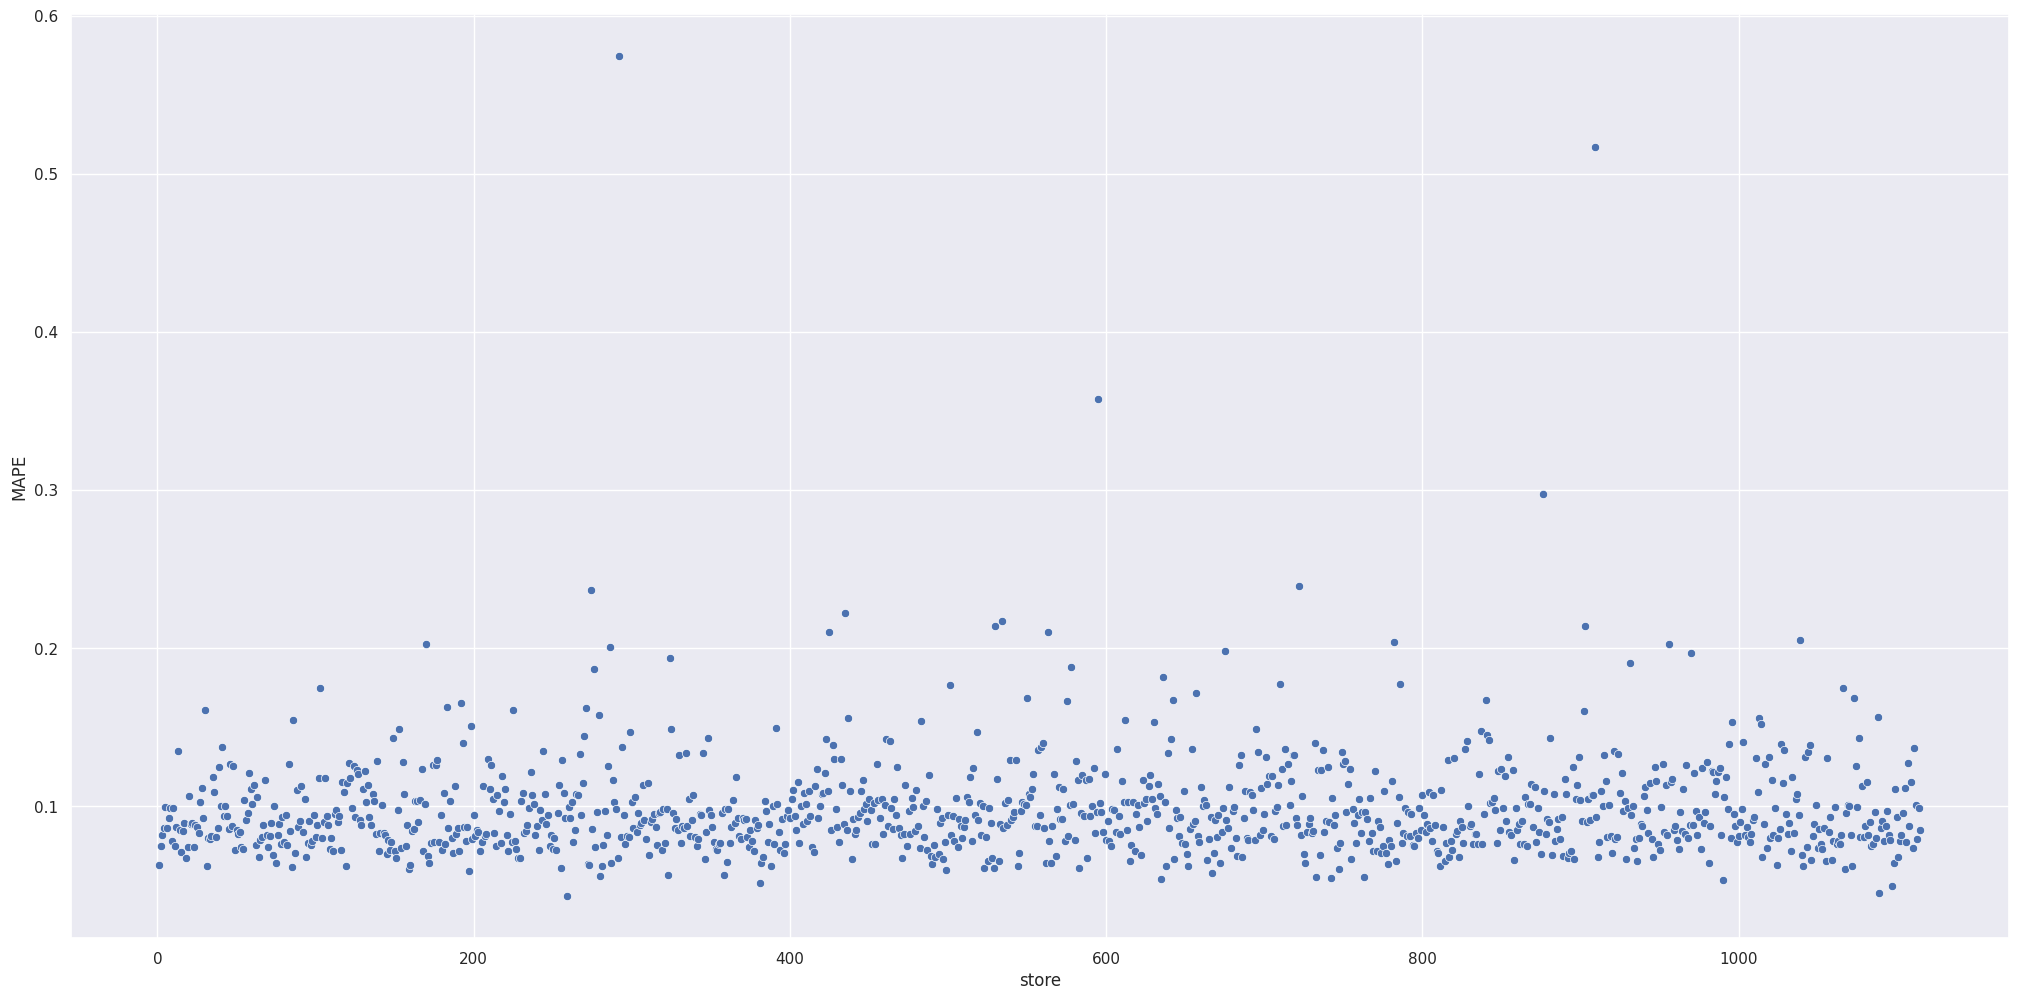

In [143]:
# showing it graficaly
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

## 9.2 Total Performance

In [144]:
df93 = df92[['prediction', 'worst_scenario', 'best_scenario']].apply(
                                                            lambda x: np.sum(x), axis = 0).reset_index().rename(
                                                            columns = {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,prediction,"R$283,278,336.00"
1,worst_scenario,"R$282,523,803.95"
2,best_scenario,"R$284,032,851.27"


## 9.3 Machine Learning Performance

In [145]:
df9['error']      = df9['sales']      - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['sales']

In [150]:
df9['prediction']

0         5712.941406
1         5961.942383
2         9374.005859
3        11631.498047
4         6611.383789
             ...     
47940     5820.101562
47941    10445.194336
47942     7215.372070
47943    21992.531250
47944     8994.938477
Name: prediction, Length: 41396, dtype: float32

<AxesSubplot: xlabel='prediction', ylabel='error'>

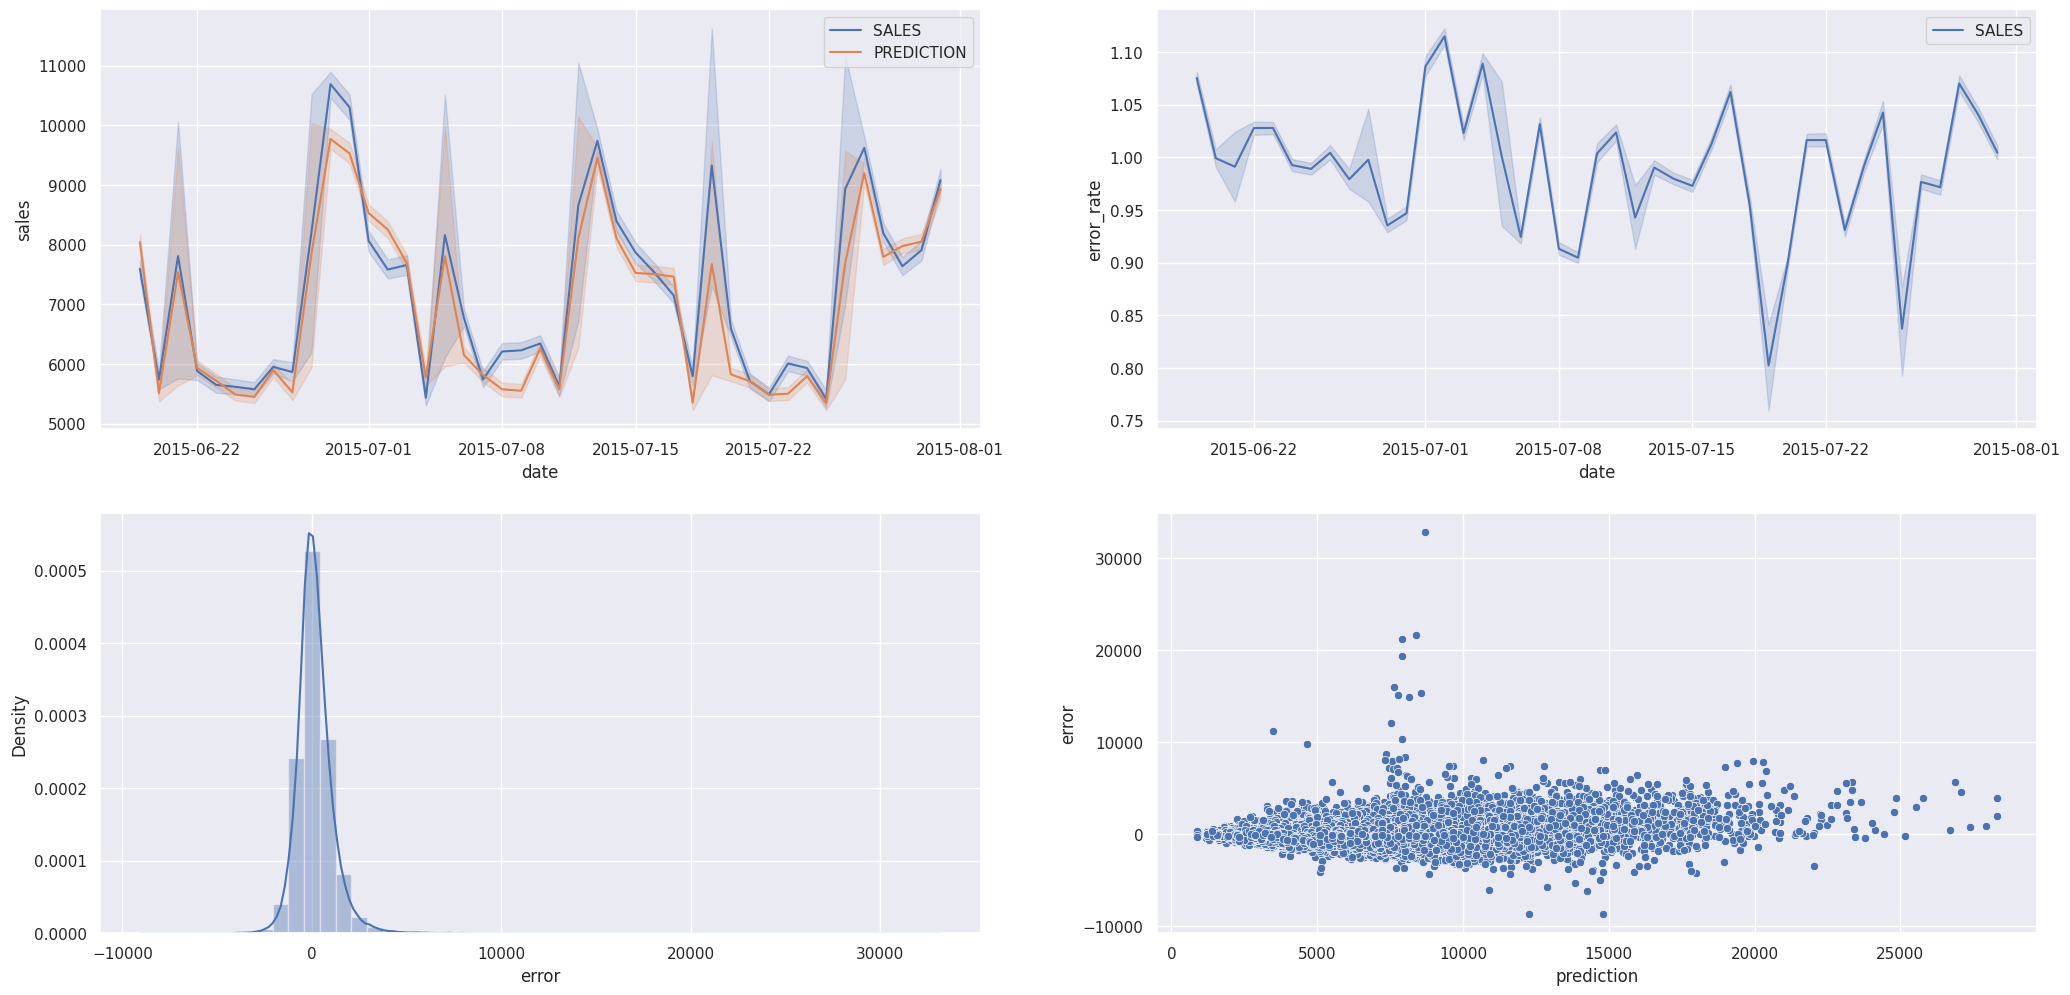

In [154]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales',      data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'prediction', data = df9, label = 'PREDICTION')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9, label = 'SALES')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(data = df9, x = 'prediction', y = 'error')

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION (crisp - modelo em produção)

In [156]:
# Save trained model
pickle.dump(model_xgb_tuned, open('/home/workpc/Documents/repos/rossmann_sales_forecast/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [160]:
import pickle
import inflection
import pandas as pd
import math
import datetime
import numpy as np


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/work/Documents/repos/curso_data_science_em_producao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb')) # rb por conta da leitura
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
    
    def data_cleaning(self, df1):
    
        #1.1 Rename Columns
    
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',   # sales and customer deleted
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
    
        cols_new = list(map(snakecase, cols_old))
    
        # rename
        df1.columns = cols_new


        ## 1.3 Data Types
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        
        # competition_distance: we are assuming tha when there is no competition distance, the competition doesn't exists 
        # at all, so we assumy tha this distance will be 200000, a number much higher than the value 75860.0
        
        # 200000.0 if math.isnam(df1['competition_distance']) else df1['competition_distance']
        # lambda x: 200000.0 if math.isnam(x['competition_distance']) else x['competition_distance']
        # df1['competition_distance'].apply(lambda x: 200000.0 if math.isnam(x) else x)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        # competition_open_since_month: we are assuming that the month of competition openning is the same as the month of 
        # the sale column
        df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(
                                                                lambda x: x['date'].month 
                                                                if math.isnan(x['competition_open_since_month']) 
                                                                else x['competition_open_since_month'],
                                                                axis = 1) # because we are using more than one column, we 
                                                                # need do specify that apply function will be apllied along
                                                                # the columns.
        
        # competition_open_since_year     
        df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(
                                                                lambda x: x['date'].year 
                                                                if math.isnan(x['competition_open_since_year']) 
                                                                else x['competition_open_since_year'],
                                                                axis = 1)
                               
        # promo2_since_week: we are assuming the same date of the row, i.e., the store doesn't make the promo2
        df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(
                                                               lambda x: x['date'].week 
                                                               if math.isnan(x['promo2_since_week']) 
                                                               else x['promo2_since_week'],
                                                                axis = 1)
        
        # promo2_since_year  
        df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year 
                                                                if math.isnan(x['promo2_since_year']) 
                                                                else x['promo2_since_year'],
                                                                axis = 1)
        
        # promo_interval: built a list and if the date is on the list the promo was made
        # dictionare
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 
                     11: 'Noc', 12: 'Dec'}
        
        # fill with 0 where in no values
        df1['promo_interval'].fillna(0, inplace = True) # inplace so the command doesn't return any value and make the 
                                                        # modification directly to the column
        
        df1['month_map'] = df1['date'].dt.month.map(month_map) # trasnform date column in date and month, and substitute
                                                               # the numbers by letters
        
        # if the months of 'month_map' are in 'promo_interval', so we assume that the store make the promo and the time
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                                     if x['promo_interval'] == 0 
                                                                     else 1 
                                                                     if x['month_map'] in x['promo_interval'].split(',') 
                                                                     else 0, 
                                                                     axis = 1)
        
        
        ## 1.6 Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
    # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                         month = x['competition_open_since_month'], 
                                                                         day = 1), 
                                                                         axis = 1)
        # divided by 30 to maintain the granularity of month
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        # converting string to datetime
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                     datetime.timedelta(days = 7))
        
        # extracting datetime in days
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' 
                                                        if x == 'a' 
                                                        else 'extra' 
                                                        if x == 'b' 
                                                        else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                          if x == 'a'  
                                                          else 'easter_holiday' 
                                                          if x == 'b' 
                                                          else 'christmas' 
                                                          if x == 'c'
                                                          else 'regular_day')
        


        ## 3.1 Filtragem das linhas (to reduce the amount of data early)
        
        # open -  if 0 the store is closed so 0 sales
        df2 = df2[(df2['open'] != 0)]
        
        ## 3.2 Seleção das colunas
        
        # customers - we do not have the prediction of how many customers the store will have, so we aren't use it now
        # open is only 1 now, promo interval and month map was used to derive another column
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    

    def data_preparation(self, df5):

        ### 5.2. Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )
                
        ### 5.3. Transformacao
        
        #### 5.3.1. Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        #### 5.3.3. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
            'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',  'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2 API Handler

In [165]:
import pickle
import json
import pandas as pd
from flask import Flask, request, Response

from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/workpc/Documents/repos/rossmann_sales_forecast/model/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST']) # endpoint | method que envia algo, e não solicita informação
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example (one row)
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0') # to run locally

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [1]:
import requests

In [166]:
# loading test dataset
df10 = pd.read_csv('/home/workpc/Documents/repos/rossmann_sales_forecast/data/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([4, 23, 25 ])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


In [ ]:
# converting dataframe to jason, for transmiting the archive between instances
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url    = 'https://botapp-rossmann.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data   = data

r = requests.post(url, data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction']))

In [ ]:
data